In [1]:
import networkx as nx
import pylab as plt
import pandas as pd
import numpy as np
import math
from operator import itemgetter
from timeit import default_timer as timer
# Create blank graph


C:\Users\allen\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [7]:

def scaleValues(E_matrix):
    #calcolo il total weight sul grafo
    W = 0
    for i in E_matrix.columns.values:
        W += E_matrix.loc[i].sum()
    print(f'Total weight: {W}')
    
    def scale(x):
        return x/W
    
    E_matrix = E_matrix.applymap(scale)
    
    return E_matrix


def computeQ(E_matrix):
    Q = 0

    #calcolo Q iniziale 
    for i in E_matrix.columns.values:
        a_i_square = pow(E_matrix.loc[i].values.sum(),2)
        e_ii = E_matrix.loc[i][i]
        Q += e_ii - a_i_square
    
    return Q


def removeDuplicatePairs(pairs_original, matrix):

    #print(f'ORIGINAL : {pairs_original}')

    pairs_copy = pairs_original.copy()

    for i in range(len(pairs_copy)):
        pairs_copy[i] = tuple(sorted(pairs_copy[i]))

    pairs_copy = sorted(pairs_copy)
    #print(f'SORTED: {pairs_copy}')


    duplicates = []

    for i in range(len(pairs_copy)-1):
        if pairs_copy[i] == pairs_copy[i+1]:
            duplicates.append(pairs_copy[i])

    #print(f'DUPLICATES: {duplicates}')


    for i in duplicates:
        pairs_original.remove(i)
        pairs_original.remove(tuple(sorted(i, reverse = True)))


    #print(f'ORIGINAL W/O DUPLICATES : {pairs_original}')


    for i in duplicates:
        if(matrix.loc[i[0]][i[1]] > matrix.loc[i[1]][i[0]]):
            pairs_original.append(i)
        else:
            pairs_original.append(tuple(sorted(i, reverse = True)))

    #print(f'ORIGINAL UPDATED : {pairs_original}')

    return pairs_original
    



def calcolaMerge(E_matrix):   
    
    print(f'Shape starting: {E_matrix.shape}')
    
    #print(f'E_matrix scalata:\n {E_matrix}')
    

    #singola iterazione per calcolare join tra communities
    
    
    #calcolo Q iniziale
    Q = computeQ(E_matrix)
    print(f'Q iniziale: {Q}')

    #definisco df in cui memorizzare DQs
    df = pd.DataFrame(columns=['pair','DQ','newQ'])
    pairs_to_try = []

    #individuo le coppie da testare => coppie con almeno un arco tra loro
    for i in E_matrix.columns.values:

        temp = pd.DataFrame(E_matrix.loc[i])    
        possible_dest = temp[temp[i]>0].index.values

        for j in possible_dest:
            if(i!=j):
                pairs_to_try.append((i,j))
    #print(pairs_to_try)
    
    if(len(pairs_to_try)>0):
        
        pairs_to_try = removeDuplicatePairs(pairs_to_try, E_matrix)

        #calcolo DQ per ogni coppia individuata
        for k in pairs_to_try:
            i = k[0]
            j = k[1]

            a_i = E_matrix.loc[i].values.sum()
            a_j = E_matrix.loc[j].values.sum()

            DQ = 2 * (E_matrix.loc[i][j] - (a_i*a_j))
            #delta_Qs.append(DQ)

            last = len(df)
            df.loc[last,'pair'] = k #aggiungo valori
            df.loc[last,'DQ'] = DQ #aggiungo valori
            df.loc[last,'newQ'] = Q +DQ #aggiungo valori


        #print(f'DQ ottenute dai merge:\n {df}')

        #identifico la coppia che fornisce maggior incremento positivo in Q => Q + DQ maggiore
        winning_pair = df.query('newQ == newQ.max()')['pair'].values[0]

        print(f'Miglior merge: {winning_pair}')


        #genero le nuove colonne merged MA NON LE AGGIUNGO SUBITO
        old_columns = E_matrix.columns.values

        #print(f'old_columns: {old_columns}')


        old_columns = np.delete(old_columns, np.argwhere(old_columns == winning_pair[0]))
        old_columns = np.delete(old_columns, np.argwhere(old_columns == winning_pair[1]))


        new_columns = np.append(old_columns,winning_pair[0]+'-'+winning_pair[1])
        #print(f'new_columns: {new_columns}')

        #genero le nuove rows merged



        #rows to merge
        merged_row = E_matrix.loc[winning_pair[0]] + E_matrix.loc[winning_pair[1]]

        #remove rows of single merged communities
        E_matrix.drop(index = winning_pair[0], inplace=True)
        E_matrix.drop(index = winning_pair[1], inplace=True)

        #add new merged row to matrix
        E_matrix.loc[winning_pair[0]+'-'+winning_pair[1]] = merged_row

        #NOW CHANGE IN THE COLUMNS

        #first compute the list of values to be insterted in the new column
        new_values = []

        #for all rows compute the merged sum value 
        for i in new_columns:
            new_value = E_matrix.loc[i][[winning_pair[0],winning_pair[1]]].sum()
            new_values.append(new_value)

        #remove the single columns of merged comm
        E_matrix = E_matrix.drop([winning_pair[0], winning_pair[1]], axis=1)

        #add the new merged column
        #E_matrix = E_matrix.insert(winning_pair[0]+winning_pair[1], new_values)


        E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values

        #print(f'AM finale: \n {E_matrix}')
        print(f'Shape obtained: {E_matrix.shape}')

        Q_finale = computeQ(E_matrix)
        
    else:
        Q_finale = float("NaN")
    
    return E_matrix, [E_matrix.columns.values, Q_finale]



#CONDIZIONI DI USCITA:
    #1: SE IL NUMERO DI COLONNE < 2 => NON CI SONO JOIN POSSIBILI DA FARE
    
    #2: SE NUM COLONNE > 2 && ESISTONO SOLO CLUSTER CHE NON HANNO COLLEGAMENTI/ARCHI TRA LORO

In [11]:
#definisco df con tante colonne quanti autori
E_matrix = pd.DataFrame(columns=['a','b','c'])


E_matrix.loc['a',['a','b','c']] = [0,1,2]
E_matrix.loc['b',['a','b','c']] = [2,0,3]
E_matrix.loc['c',['a','b','c']] = [1,1,0]

E_matrix


E_matrix = scaleValues(E_matrix)



Total weight: 10


In [ ]:
clusters_iterations = []

start = timer()



while(E_matrix.shape[0]>1):
    E_matrix, clusters = calcolaMerge(E_matrix)
    clusters_iterations.append(clusters)
    if(math.isnan(clusters[-1])):
        break
    else:
        print(f'Q obtained: {clusters[-1]}\n')
        print('\n########\n')
    
end = timer()
print(end - start)


In [38]:
grafo = pd.read_csv('./graph.csv', sep=' ')
grafo

From  \
0     00168ef7c9a4fed70901c32e2a3311a60893e328859fcd...   
1     00a5614eecf54e2d713de00b7a6a75814ca14d57327791...   
2     00ef89995ea4bb4aa275935f61e7a0e088efbc28666464...   
3     00ef89995ea4bb4aa275935f61e7a0e088efbc28666464...   
4     00f1809b78bdb4854c678a8900fca8c0454b78bc5a4181...   
...                                                 ...   
1864  ff9af28010b1a78e3af698c64734cecf907988b927435d...   
1865  ff9af28010b1a78e3af698c64734cecf907988b927435d...   
1866  ff9af28010b1a78e3af698c64734cecf907988b927435d...   
1867  ff9af28010b1a78e3af698c64734cecf907988b927435d...   
1868  ff9af28010b1a78e3af698c64734cecf907988b927435d...   

                                                     To  Weight  
0     8461c5ed9597d635ec105c100be87336126720a6d9cdf6...       1  
1     cccdcf360fd819c26119284d841a2492a2e84b03b1ebac...       1  
2     7c7699a363945e1b8c78c1cb3033b2871ff3dd535455d5...       1  
3     cd9275d14a989731762f349209159de4f515486f567968...       1  
4     3704f39cb7a44719f67404ea0b169a1f35b4884e736598...       1  
...                                                 ...     ...  
1864  639f14c72f820958ec46d4421532e2e691aff9854ec6b5...       1  
1865  a3a3de2d5f918c45f4aa596c92077c6dbc3dd1d78b3c08...       1  
1866  b0f7ce457dedd8058ef12e0e4eb62b793b086dded943b7...       1  
1867  d5143ff1c465bd04cdc7a8f2c30d9ed7a1528b167b417c...       1  
1868  e8e21119f3fec2cc5279e44167d21be3f9d85ba149ea96...       1  

[1869 rows x 3 columns]

In [59]:
DF = pd.read_csv('./AM_Matrix.csv')
DF.rename(columns={'Unnamed: 0':'From'}, inplace = True)
DF.set_index('From',inplace = True,drop=True)

#SETTO A 0 I VALORI SULLA DIAGONALE => AUTOCITAZIONI
for i in DF.columns.values:
    DF.loc[i][i] = 0


DF

00168ef7c9a4fed70901c32e2a3311a60893e328859fcd615100cf40da97344e  \
From                                                                                                                   
00168ef7c9a4fed70901c32e2a3311a60893e328859fcd6...                                                  0                  
00a5614eecf54e2d713de00b7a6a75814ca14d573277911...                                                  0                  
00ef89995ea4bb4aa275935f61e7a0e088efbc28666464b...                                                  0                  
00f1809b78bdb4854c678a8900fca8c0454b78bc5a41811...                                                  0                  
010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f653...                                                  0                  
...                                                                                               ...                  
fe8853528bdee7911b91829edffd3479ee6376168c87906...                                                  0                  
feca281ea68a9c47ec6fb59ec5d9f31d76105ad9d058a0d...                                                  0                  
ff24acad38556b1c8d521f449c0399008632be8d96b0c25...                                                  0                  
ff665fdeae13e20a855549e1e389b3992088650b2feea22...                                                  0                  
ff9af28010b1a78e3af698c64734cecf907988b927435d9...                                                  0                  

                                                    00a5614eecf54e2d713de00b7a6a75814ca14d5732779117f77346fa01ddca12  \
From                                                                                                                   
00168ef7c9a4fed70901c32e2a3311a60893e328859fcd6...                                                  0                  
00a5614eecf54e2d713de00b7a6a75814ca14d573277911...                                                  0                  
00ef89995ea4bb4aa275935f61e7a0e088efbc28666464b...                                                  0                  
00f1809b78bdb4854c678a8900fca8c0454b78bc5a41811...                                                  0                  
010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f653...                                                  0                  
...                                                                                               ...                  
fe8853528bdee7911b91829edffd3479ee6376168c87906...                                                  0                  
feca281ea68a9c47ec6fb59ec5d9f31d76105ad9d058a0d...                                                  0                  
ff24acad38556b1c8d521f449c0399008632be8d96b0c25...                                                  0                  
ff665fdeae13e20a855549e1e389b3992088650b2feea22...                                                  0                  
ff9af28010b1a78e3af698c64734cecf907988b927435d9...                                                  0                  

                                                    00ef89995ea4bb4aa275935f61e7a0e088efbc28666464b11d6dd409616db1a2  \
From                                                                                                                   
00168ef7c9a4fed70901c32e2a3311a60893e328859fcd6...                                                  0                  
00a5614eecf54e2d713de00b7a6a75814ca14d573277911...                                                  0                  
00ef89995ea4bb4aa275935f61e7a0e088efbc28666464b...                                                  0                  
00f1809b78bdb4854c678a8900fca8c0454b78bc5a41811...                                                  0                  
010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f653...                                                  0                  
...                                                                                       

In [63]:
#AUTORI CHE NON CITANO NESSUNO => possono essere i primi della frontiera che non citano nessuno
c = 0
for i in DF.columns.values: 
    if(DF.loc[i].sum()==0):
        #print(i)
        c+=1
c
        

193

In [64]:
#AUTORI CHE NON VENGONO CITATI DA NESSUNO => POSSONO ESSERE GLI ULTIMI ARRIVATI CHE NON VENGONO CITATI
c = 0
for i in DF.columns.values: 
    if(DF[i].sum()==0):
        #print(i)
        c+=1
c
        

321

In [62]:
#AUTORI CHE NON CITANO NESSUNO E NON VENGONO CITATI
c = 0
for i in DF.columns.values: 
    if(DF.loc[i].sum()==0):
        if(DF[i].sum()==0):
            print(i)
            c+=1
c      


#SE LASCIO LE AUTO CITAZIONI SONO 0
#SE TOLGO LE AUTO CITAZIONI SONO 7

09be04ef4c0f6dd3183ecac4b90b7529d671ff6f9ae7a1f31369448a049b7dcf
0af1644d4364f37e97446be6754e55d70f1d4caf33244d52fe31facee3feb05c
76c1522e7cfd068a4c3a0b5cc59dc386551338eb0d95d14d3acedb873c370b4c
84899e790af7fa2c6e589c6582dd4f66c9ef66c8ad3dccf557d1415e3512311e
b9041e1ea47076018faa3830c250d5d0047241e3d60c006d6d3eaffa9b2c63a3
d1ec6f5c7fe4d25cd2d40d368c0ba982d396779bf6a2e8451661b7b96eec2ea8
f9d8e16594d958290914bd9d9faca9e2356a920069affcb3a085b2f487967c4c


7

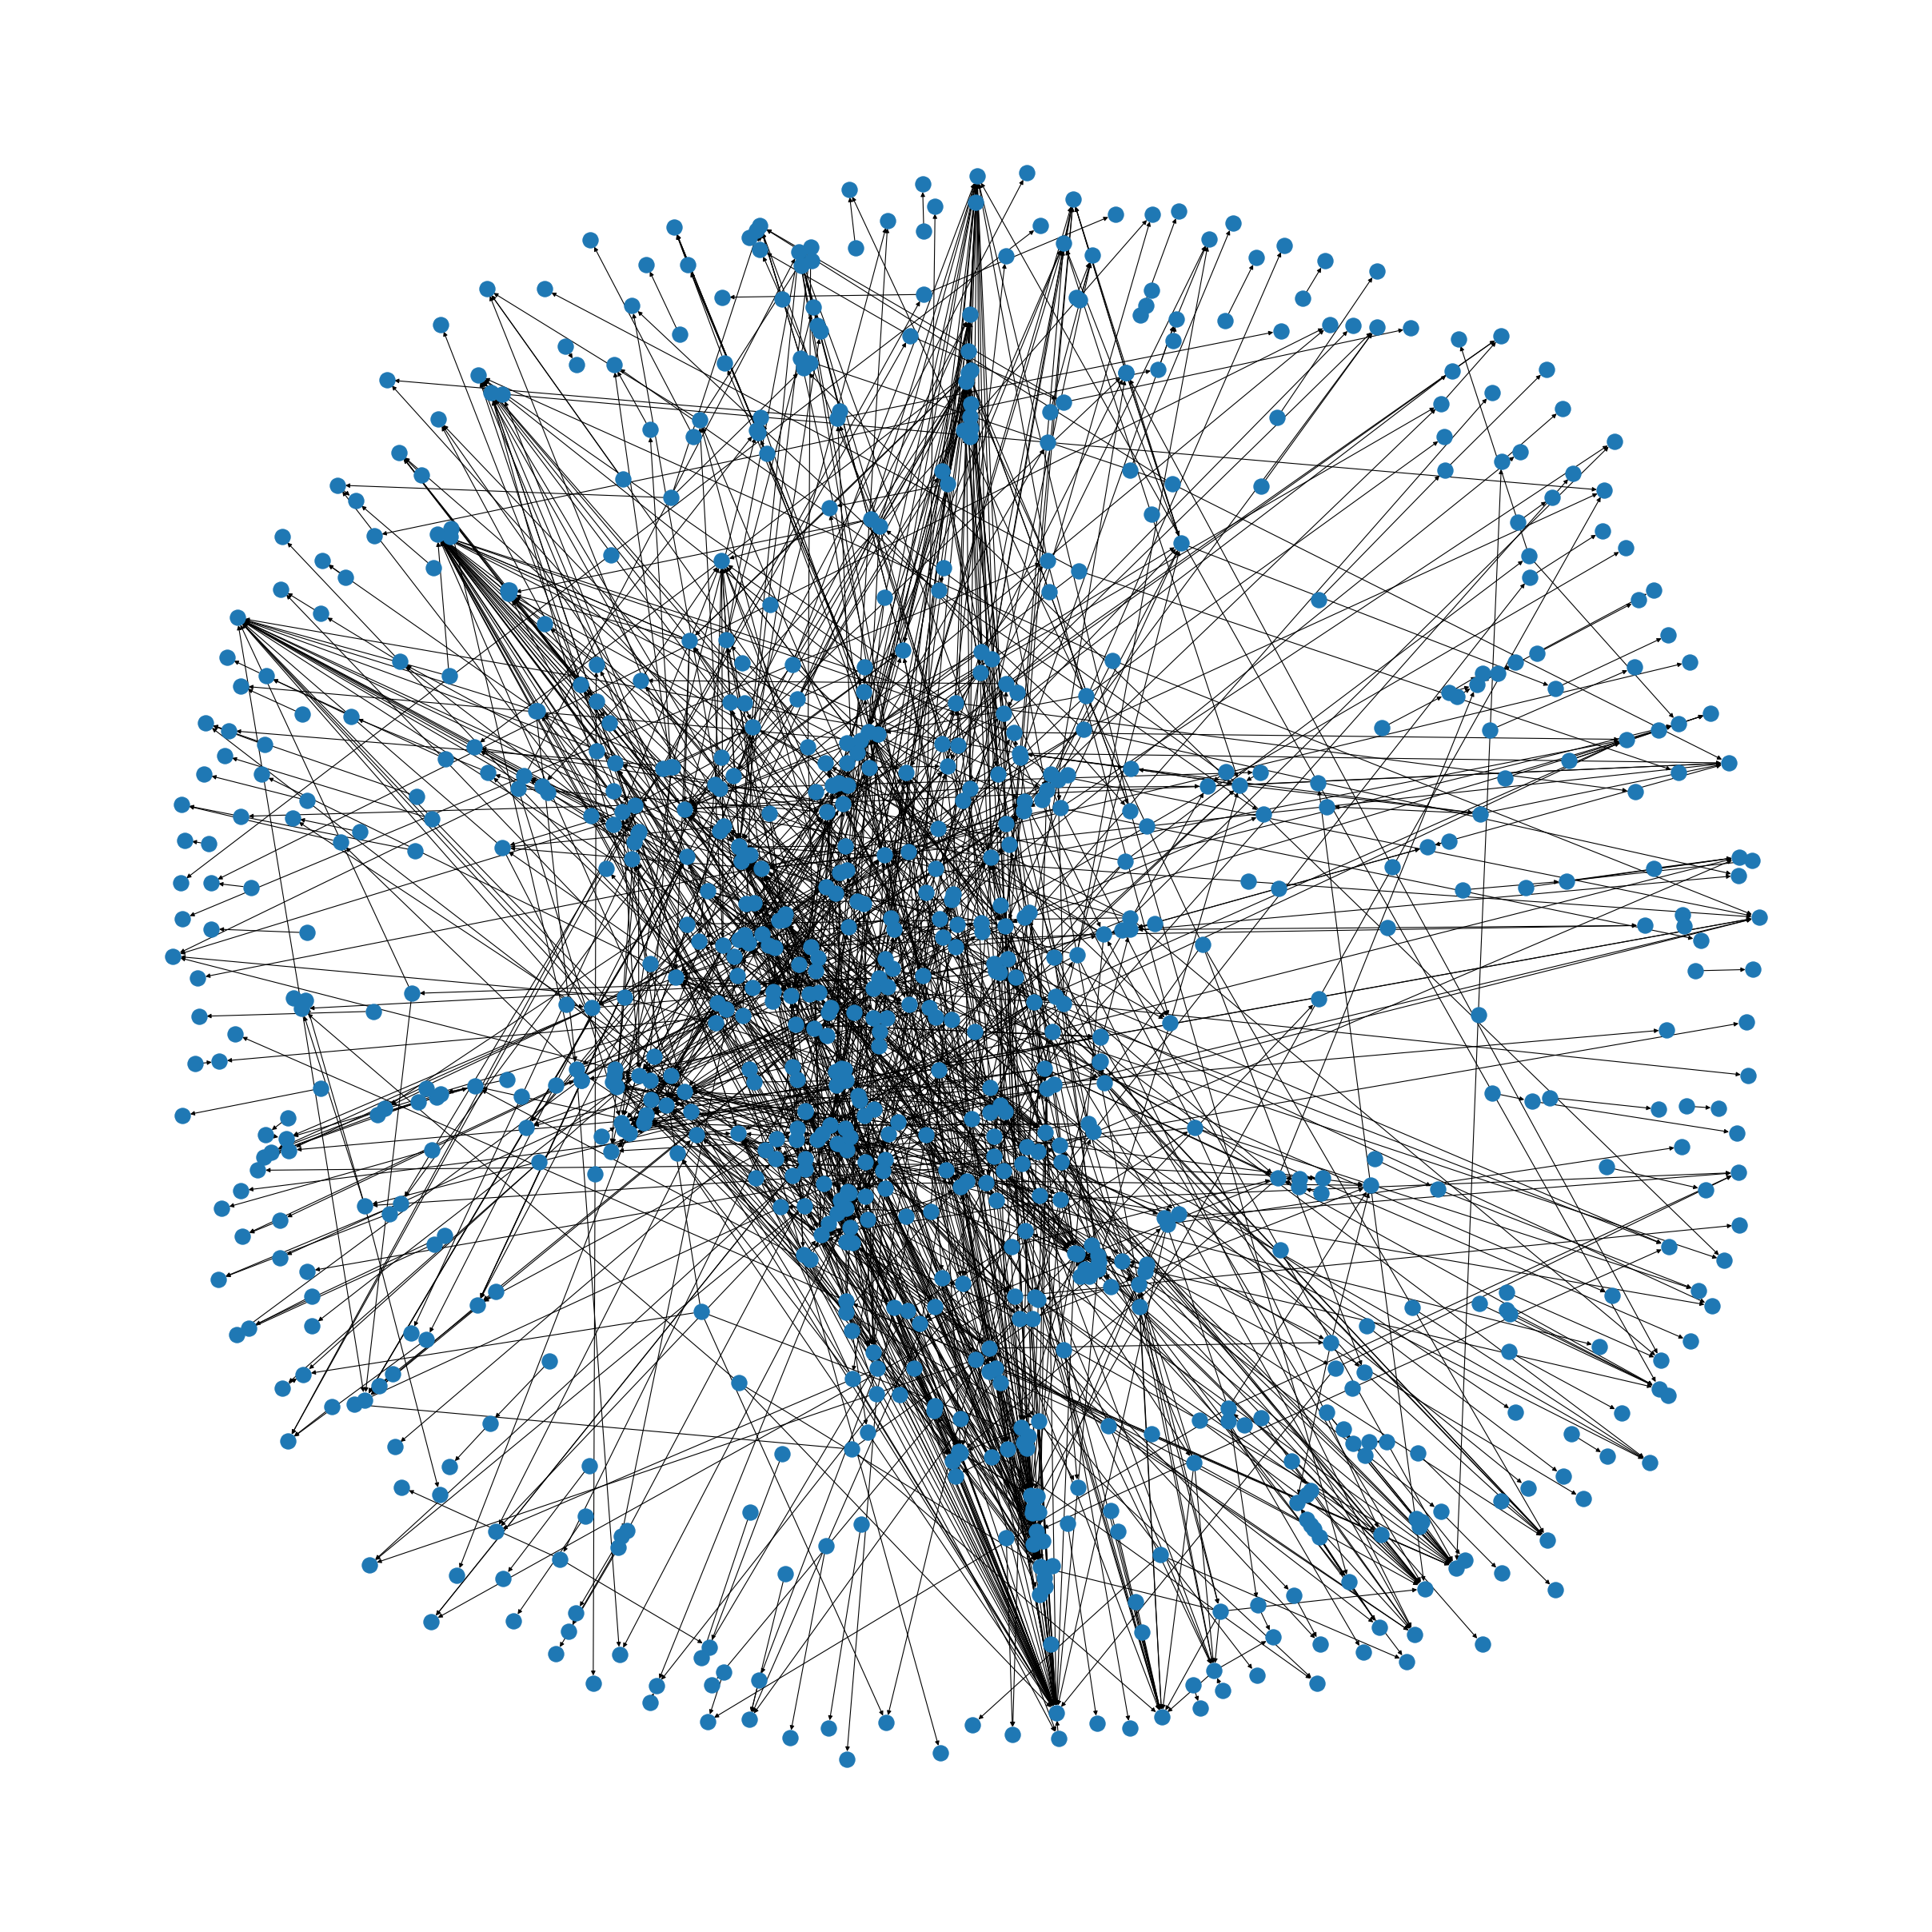

In [101]:
#STAMPA GRAFO
D=nx.DiGraph()

#for i in DF.columns.values:
#    D.add_node(str(i),nodeId = str(i))
    
for i in DF.columns.values: 
    for j in DF.columns.values:
        w = DF.loc[i][j]
        if(i!=j and w > 0):           
            
            D.add_weighted_edges_from([(str(i),str(j),w)])
    
# Plot graph
figure(figsize=(30, 30), dpi=80)
nx.draw(D, with_labels=False)
plt.show()
#D.nodes

In [37]:
len(D.nodes)

NameError: name 'D' is not defined

871
871


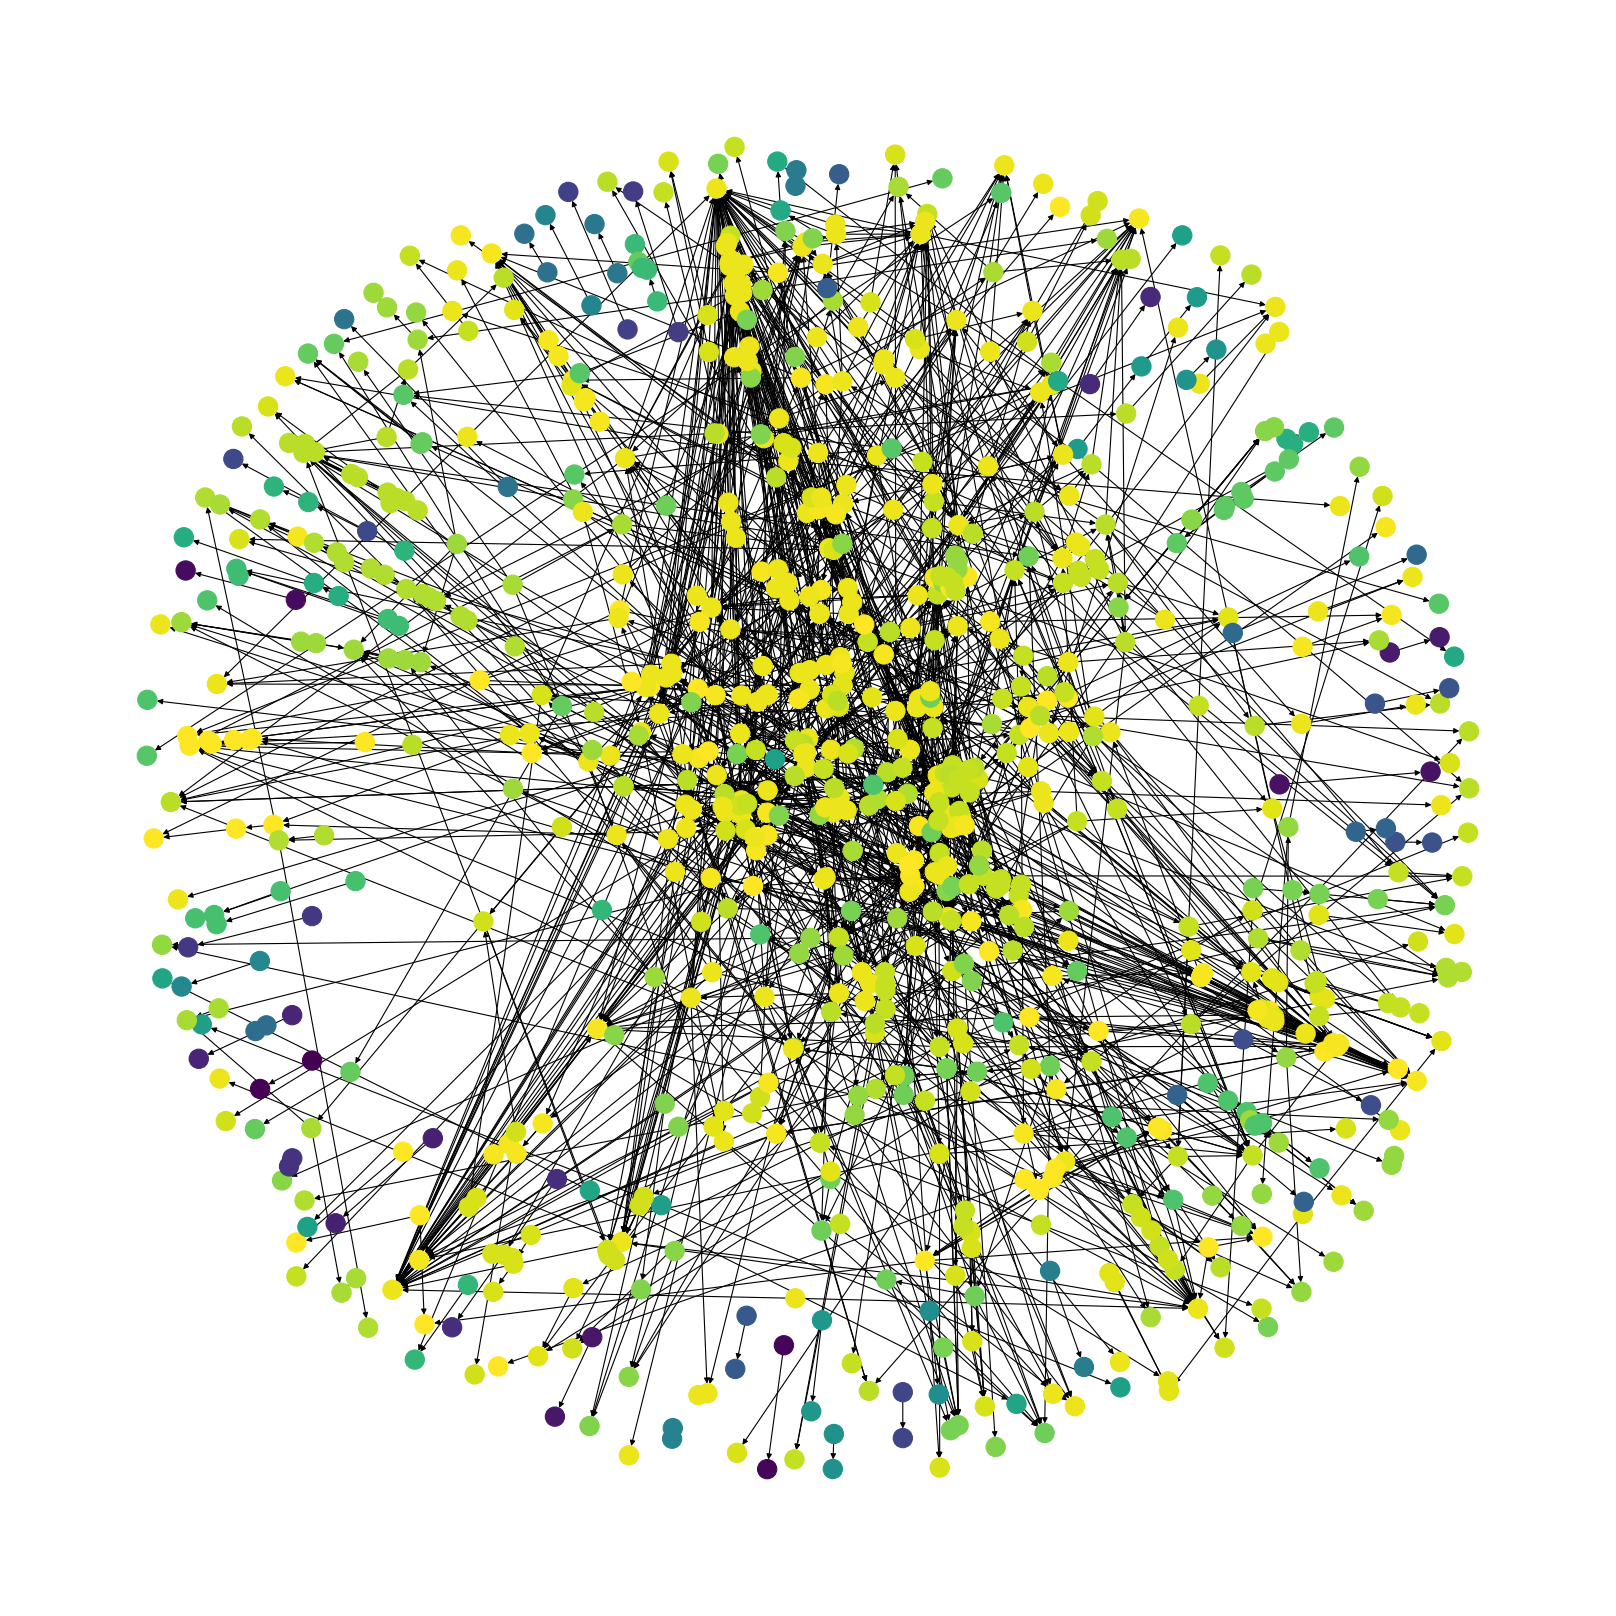

In [120]:
color_map = []
for node in D:
    for j in range(len(Best_Clusters_DF)):
        #splitted = Best_Clusters_DF.iloc[j]['cluster_authors'].split("-")
        if(node in Best_Clusters_DF.iloc[j]['cluster_authors']):
            color_map.append(j)
            continue
print(len(D.nodes))
print(len(color_map))


from matplotlib.pyplot import figure
figure(figsize=(20, 20), dpi=80)

nx.draw(D, node_color=color_map, with_labels=False)
plt.show()

In [7]:
DF = scaleValues(DF)
clusters_iterations = []
while(DF.shape[0]>1):
    DF, clusters = calcolaMerge(DF)
    clusters_iterations.append(clusters)
    if(math.isnan(clusters[-1])):
        break
    else:
        print(f'Q obtained: {clusters[-1]}\n')
        print('\n########\n')
    


Total weight: 1882
Shape starting: (878, 878)
Q iniziale: -0.0023975669720750657
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063 -0.001335
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001059 -0.001339
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001063 -0.001335
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056 -0.001342
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106 -0.001338
...                                                 ...       ...       ...
1808  (d74d15bb159e8729ac988fe8db16d28f397f137cd29e3...  0.001059 -0.001338
1809  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055 -0.001343
1810  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119 -0.000279
1811  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057 -0.001341
1812  (cbcc9ec3465f367f7de79a0ae71a56218d2c128262c69...  0.

Shape obtained: (871, 871)
Q obtained: 0.008671558170079311


########

Shape starting: (871, 871)
Q iniziale: 0.008671558170079311
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.009734
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001059   0.00973
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.009727
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001046  0.009717
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.009731
...                                                 ...       ...       ...
1776  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.010753
1777  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.009726
1778  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119   0.01079
1779  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057  0.009729
1780  (c

Shape obtained: (864, 864)
Q obtained: 0.017026904021656023


########

Shape starting: (864, 864)
Q iniziale: 0.017026904021656023
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.01809
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.018073
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.018083
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103  0.018057
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.018087
...                                                 ...       ...       ...
1765  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093   0.01912
1766  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119  0.019146
1767  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057  0.018084
1768  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.018073
1769  (c

Shape obtained: (857, 857)
Q obtained: 0.024985855145395544


########

Shape starting: (857, 857)
Q iniziale: 0.024985855145395544
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.026049
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.026032
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.026042
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103  0.026016
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.026046
...                                                 ...       ...       ...
1748  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093  0.027079
1749  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119  0.027104
1750  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057  0.026043
1751  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.026032
1752  (c

Shape obtained: (850, 850)
Q obtained: 0.03399169490932046


########

Shape starting: (850, 850)
Q iniziale: 0.03399169490932046
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.035054
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.035038
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.035048
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103  0.035022
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.035052
...                                                 ...       ...       ...
1738  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093  0.036084
1739  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119   0.03611
1740  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057  0.035049
1741  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.035038
1742  (cbc

Shape obtained: (843, 843)
Q obtained: 0.0419286241037357


########

Shape starting: (843, 843)
Q iniziale: 0.0419286241037357
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.042991
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.042975
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.042985
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103  0.042959
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.042989
...                                                 ...       ...       ...
1720  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093  0.044021
1721  (b7f1a194702f504271bc7c69dc974b9944fd2aef76631...  0.002119  0.044047
1722  (ff9af28010b1a78e3af698c64734cecf907988b927435...  0.001057  0.042986
1723  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.042975
1724  (cbcc9

Shape obtained: (836, 836)
Q obtained: 0.05031050920347245


########

Shape starting: (836, 836)
Q iniziale: 0.05031050920347245
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.051373
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.051357
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.051366
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103   0.05134
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106   0.05137
...                                                 ...       ...       ...
1693  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.002047  0.052358
1694  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093  0.052403
1695  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.051357
1696  (ff9af28010b1a78e3af698c64734cecf907988b927435...   0.00104  0.051351
1697  (cbc

Shape obtained: (830, 830)
Q obtained: 0.05764437633331488


########

Shape starting: (830, 830)
Q iniziale: 0.05764437633331488
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.058707
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001046  0.058691
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056    0.0587
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00103  0.058674
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.058704
...                                                 ...       ...       ...
1681  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.002047  0.059692
1682  (9f66b6f46a9adaebd9f69738418dbea1b9b3c2b739313...  0.002093  0.059737
1683  (cccdcf360fd819c26119284d841a2492a2e84b03b1eba...  0.001046  0.058691
1684  (ff9af28010b1a78e3af698c64734cecf907988b927435...   0.00104  0.058684
1685  (cbc

Shape obtained: (824, 824)
Q obtained: 0.0683238827258857


########

Shape starting: (824, 824)
Q iniziale: 0.0683238827258857
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.069387
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001034  0.069358
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056   0.06938
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001005  0.069329
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.069384
...                                                 ...       ...       ...
1661  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.069379
1662  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.002047  0.070371
1663  (c9f7219da7e6b0fcbda323e8497171f18950df7c72678...  0.002097   0.07042
1664  (ff9af28010b1a78e3af698c64734cecf907988b927435...   0.00104  0.069364
1665  (cbcc9

Shape obtained: (818, 818)
Q obtained: 0.07871879803180418


########

Shape starting: (818, 818)
Q iniziale: 0.07871879803180418
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.079781
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001032  0.079751
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.079775
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001002  0.079721
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.079779
...                                                 ...       ...       ...
1632  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.080815
1633  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.079774
1634  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.002047  0.080766
1635  (ff9af28010b1a78e3af698c64734cecf907988b927435...   0.00104  0.079759
1636  (cbc

Shape obtained: (813, 813)
Q obtained: 0.09087320902424782


########

Shape starting: (813, 813)
Q iniziale: 0.09087320902424782
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.091936
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001032  0.091905
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.091929
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001002  0.091875
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.091933
...                                                 ...       ...       ...
1616  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.092969
1617  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.091928
1618  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.002047  0.092921
1619  (ff9af28010b1a78e3af698c64734cecf907988b927435...   0.00104  0.091913
1620  (cbc

Shape obtained: (807, 807)
Q obtained: 0.10168371766305545


########

Shape starting: (807, 807)
Q iniziale: 0.10168371766305545
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.102746
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001032  0.102716
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056   0.10274
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001002  0.102685
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.102744
...                                                 ...       ...       ...
1586  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.103765
1587  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.102739
1588  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096   0.10378
1589  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.102739
1590  (ec1

Shape obtained: (802, 802)
Q obtained: 0.11416676360080003


########

Shape starting: (802, 802)
Q iniziale: 0.11416676360080003
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.115229
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.001032  0.115199
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.115223
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001002  0.115168
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.115227
...                                                 ...       ...       ...
1566  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.116248
1567  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.115222
1568  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.116263
1569  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.115222
1570  (ec1

Shape obtained: (798, 798)
Q obtained: 0.12074397982565407


########

Shape starting: (798, 798)
Q iniziale: 0.12074397982565407
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.121807
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000993  0.121737
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056    0.1218
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.000923  0.121667
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.121804
...                                                 ...       ...       ...
1519  (e2b50f716ce93899beceb23b9a38ee893e3f8c59a11eb...  0.002055  0.122799
1520  (e2b50f716ce93899beceb23b9a38ee893e3f8c59a11eb...  0.000853  0.121597
1521  (e65c040ee4e62e1657f4758d2a234cc8e87eafaaddac1...  0.002838  0.123582
1522  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.000783  0.121527
1523  (fdf

Shape obtained: (795, 795)
Q obtained: 0.12632795057149732


########

Shape starting: (795, 795)
Q iniziale: 0.12632795057149732
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.127391
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000986  0.127314
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.127384
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...   0.00091  0.127238
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.127388
...                                                 ...       ...       ...
1509  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.128409
1510  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.127383
1511  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.128424
1512  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.127383
1513  (ec1

Shape obtained: (792, 792)
Q obtained: 0.13082324747792443


########

Shape starting: (792, 792)
Q iniziale: 0.13082324747792443
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.131886
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000977    0.1318
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.131879
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.000891  0.131714
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.131883
...                                                 ...       ...       ...
1502  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.132905
1503  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.131879
1504  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.132919
1505  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.131878
1506  (ec1

Shape obtained: (789, 789)
Q obtained: 0.13614408440158515


########

Shape starting: (789, 789)
Q iniziale: 0.13614408440158515
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.137207
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00097  0.137114
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056    0.1372
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.000877  0.137022
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.137204
...                                                 ...       ...       ...
1484  (cd9275d14a989731762f349209159de4f515486f56796...  0.002081  0.138225
1485  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.137199
1486  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096   0.13824
1487  (90a41f2da7704ed79cd83a1861e3adf9e9537a574cc88...  0.001055  0.137199
1488  (ec1

Shape obtained: (786, 786)
Q obtained: 0.13919835659940757


########

Shape starting: (786, 786)
Q iniziale: 0.13919835659940757
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.140261
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000948  0.140146
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.140254
3     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.000833  0.140032
4     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.140258
...                                                 ...       ...       ...
1438  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.000719  0.139917
1439  (ec100ec495ae892b74f771a1a5da2f7d7b148d8560cab...  0.000375  0.139573
1440  (e65c040ee4e62e1657f4758d2a234cc8e87eafaaddac1...  0.002615  0.141813
1441  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.000604  0.139803
1442  (fdf

Shape obtained: (783, 783)
Q obtained: 0.1438173151089634


########

Shape starting: (783, 783)
Q iniziale: 0.1438173151089634
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.14488
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000932   0.14475
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.144873
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.144877
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.144877
...                                                 ...       ...       ...
1397  (cd9275d14a989731762f349209159de4f515486f56796...  0.002405  0.146223
1398  (fdfa6a73ea5fbfcbd5c7650951ec26f5fbea28d8d4b27...  0.000802  0.144619
1399  (fdfa6a73ea5fbfcbd5c7650951ec26f5fbea28d8d4b27...   0.00028  0.144097
1400  (e65c040ee4e62e1657f4758d2a234cc8e87eafaaddac1...  0.002536  0.146353
1401  (f4003

Shape obtained: (781, 781)
Q obtained: 0.1471426264369309


########

Shape starting: (781, 781)
Q iniziale: 0.1471426264369309
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.148205
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000924  0.148066
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.148199
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.148203
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.148203
...                                                 ...       ...       ...
1389  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000924  0.148066
1390  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.148144
1391  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.148198
1392  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.149239
1393  (90a41

Shape obtained: (779, 779)
Q obtained: 0.14999079596287218


########

Shape starting: (779, 779)
Q iniziale: 0.14999079596287218
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.151053
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000918  0.150909
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.151047
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.151051
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.151051
...                                                 ...       ...       ...
1382  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000918  0.150909
1383  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.150993
1384  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.151046
1385  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.152087
1386  (90a

Shape obtained: (777, 777)
Q obtained: 0.1527215151990839


########

Shape starting: (777, 777)
Q iniziale: 0.1527215151990839
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.153784
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00091  0.153632
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.153777
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.153781
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.153781
...                                                 ...       ...       ...
1373  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00091  0.153632
1374  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.001211  0.153932
1375  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.153777
1376  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.154818
1377  (90a41

Shape obtained: (775, 775)
Q obtained: 0.15567866504193767


########

Shape starting: (775, 775)
Q iniziale: 0.15567866504193767
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.156741
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000907  0.156586
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.156735
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.156739
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.156739
...                                                 ...       ...       ...
1361  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.002256  0.157935
1362  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002   0.15668
1363  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.156734
1364  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.157775
1365  (90a

Shape obtained: (773, 773)
Q obtained: 0.15740879815603048


########

Shape starting: (773, 773)
Q iniziale: 0.15740879815603048
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.158471
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000898  0.158307
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.158465
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.158469
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.158469
...                                                 ...       ...       ...
1350  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.002202  0.159611
1351  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.158411
1352  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.158464
1353  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.159505
1354  (90a

Shape obtained: (771, 771)
Q obtained: 0.1619673375261581


########

Shape starting: (771, 771)
Q iniziale: 0.1619673375261581
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.16303
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000892   0.16286
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.163023
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.163027
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.163027
...                                                 ...       ...       ...
1340  (cd9275d14a989731762f349209159de4f515486f56796...  0.000856  0.162823
1341  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.162969
1342  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.163023
1343  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.164063
1344  (90a41

Shape obtained: (769, 769)
Q obtained: 0.16483075300317007


########

Shape starting: (769, 769)
Q iniziale: 0.16483075300317007
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.165893
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000889   0.16572
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.165887
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.165891
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.165891
...                                                 ...       ...       ...
1330  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000889   0.16572
1331  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.002148  0.166979
1332  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.165886
1333  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.166927
1334  (90a

Shape obtained: (767, 767)
Q obtained: 0.16697365612587964


########

Shape starting: (767, 767)
Q iniziale: 0.16697365612587964
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.168036
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000886   0.16786
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056   0.16803
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.168034
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.168034
...                                                 ...       ...       ...
1326  (ed7e38aa001d73624842a043c380dd21bc69f70dba27f...  0.002304  0.169278
1327  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000709  0.167683
1328  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.002481  0.169455
1329  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000886   0.16786
1330  (f9f

Shape obtained: (765, 765)
Q obtained: 0.16873879846094952


########

Shape starting: (765, 765)
Q iniziale: 0.16873879846094952
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.169801
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000881   0.16962
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.169795
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.169799
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.169799
...                                                 ...       ...       ...
1323  (f78b77e621a8e0f8354d351f639b822adc209dd29f862...  0.002282  0.171021
1324  (f78b77e621a8e0f8354d351f639b822adc209dd29f862...    0.0007  0.169439
1325  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.002463  0.171202
1326  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000881   0.16962
1327  (f9f

Shape obtained: (763, 763)
Q obtained: 0.1720426525244472


########

Shape starting: (763, 763)
Q iniziale: 0.1720426525244472
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.173105
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000875  0.172918
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.173099
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.173103
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.173103
...                                                 ...       ...       ...
1310  (cd9275d14a989731762f349209159de4f515486f56796...  0.000856  0.172899
1311  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.173044
1312  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.173098
1313  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.174139
1314  (90a41

Shape obtained: (761, 761)
Q obtained: 0.17565763692275727


########

Shape starting: (761, 761)
Q iniziale: 0.17565763692275727
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.17672
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00087  0.176528
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.176714
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.176718
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.176718
...                                                 ...       ...       ...
1304  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.002033   0.17769
1305  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.176659
1306  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.176713
1307  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.177754
1308  (90a

Shape obtained: (759, 759)
Q obtained: 0.1779129083515062


########

Shape starting: (759, 759)
Q iniziale: 0.1779129083515062
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.178976
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000863  0.178776
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.178969
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.178973
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.178973
...                                                 ...       ...       ...
1298  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.001989  0.179902
1299  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.178915
1300  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.178968
1301  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.180009
1302  (90a41

Shape obtained: (757, 757)
Q obtained: 0.18149118953427576


########

Shape starting: (757, 757)
Q iniziale: 0.18149118953427576
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.182554
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000859  0.182351
2     (00ef89995ea4bb4aa275935f61e7a0e088efbc2866646...  0.001056  0.182547
3     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.182551
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.182551
...                                                 ...       ...       ...
1293  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.002172  0.183663
1294  (f400319298bb3348638cea8a49183fc5358989ae27433...  0.000656  0.182147
1295  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000859  0.182351
1296  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000859  0.182351
1297  (f9f

Shape obtained: (755, 755)
Q obtained: 0.18443365809091333


########

Shape starting: (755, 755)
Q iniziale: 0.18443365809091333
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.185496
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000854  0.185288
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.185494
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.185494
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.185474
...                                                 ...       ...       ...
1283  (f9f920b6837f2a0255a615a82788e157beece138ba56e...  0.003001  0.187434
1284  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.185435
1285  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.185489
1286  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096   0.18653
1287  (90a

Shape obtained: (753, 753)
Q obtained: 0.18679903916628368


########

Shape starting: (753, 753)
Q iniziale: 0.18679903916628368
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.187862
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000849  0.187648
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.187859
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.187859
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.187839
...                                                 ...       ...       ...
1276  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001699  0.188498
1277  (e65c040ee4e62e1657f4758d2a234cc8e87eafaaddac1...  0.002121   0.18892
1278  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000636  0.187435
1279  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000849  0.187648
1280  (f9a

Shape obtained: (751, 751)
Q obtained: 0.18753028015282092


########

Shape starting: (751, 751)
Q iniziale: 0.18753028015282092
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.188593
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000841  0.188372
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106   0.18859
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.18859
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104   0.18857
...                                                 ...       ...       ...
1267  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.189518
1268  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.188532
1269  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.188586
1270  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.189626
1271  (90a

Shape obtained: (749, 749)
Q obtained: 0.18965567866504196


########

Shape starting: (749, 749)
Q iniziale: 0.18965567866504196
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.190718
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000841  0.190497
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.190716
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.190716
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.190696
...                                                 ...       ...       ...
1259  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.191643
1260  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.190657
1261  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.190711
1262  (f02d23335f3e0a8c5310227d103f1fb55be948842fe5e...  0.002096  0.191752
1263  (90a

Shape obtained: (742, 742)
Q obtained: 0.19803078778652505


########

Shape starting: (742, 742)
Q iniziale: 0.19803078778652505
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.199093
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000841  0.198872
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.199091
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.199091
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.199071
...                                                 ...       ...       ...
1241  (9be045d7f1caabb81aeaeadc2ed20640f3e95bf98835f...  0.001002  0.199033
1242  (fa12e7c3936fa635376823ff0b33c5d35e2177ce55884...   0.00088  0.198911
1243  (80af4b1a080a93e339ccb7bc47b53f29c2140aef39c67...  0.002086  0.200117
1244  (a0cbda76c76d8216989f9393a984567bb2d61ff0bbb6a...  0.001055  0.199086
1245  (f02

Shape obtained: (736, 736)
Q obtained: 0.20580848149198003


########

Shape starting: (736, 736)
Q iniziale: 0.20580848149198003
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.206871
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000841   0.20665
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.206868
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.206868
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.206849
...                                                 ...       ...       ...
1223  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000841   0.20665
1224  (fa12e7c3936fa635376823ff0b33c5d35e2177ce55884...  0.001728  0.207536
1225  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.207796
1226  (fa12e7c3936fa635376823ff0b33c5d35e2177ce55884...  0.001003  0.206812
1227  (80a

Shape obtained: (732, 732)
Q obtained: 0.2101993154003305


########

Shape starting: (732, 732)
Q iniziale: 0.2101993154003305
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.211262
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000828  0.211028
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.211259
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.211259
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.211239
...                                                 ...       ...       ...
1204  (ebd6c3315ed21e34676cbf34b1c60b53adbe94187265f...  0.002016  0.212216
1205  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000594  0.210793
1206  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000828  0.211028
1207  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000828  0.211028
1208  (fa12e

Q iniziale: 0.2124161896189755
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.213479
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000826  0.213242
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.213476
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.213476
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.213456
...                                                 ...       ...       ...
1200  (18d5606d8433ab51f2ea2fade44edc443f42a70f5a228...  0.002086  0.214502
1201  (1d58558bd925961b0d42db9713ee1321fe41b3ddea6ef...  0.002054   0.21447
1202  (fa12e7c3936fa635376823ff0b33c5d35e2177ce55884...  0.000814   0.21323
1203  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.214404
1204  (fa12e7c3936fa635376823ff0b33c5d35e2177ce55884...  0.001003   0.21342

[1205 rows x 3 columns]
Miglior 

Shape obtained: (724, 724)
Q obtained: 0.21908375222054458


########

Shape starting: (724, 724)
Q iniziale: 0.21908375222054458
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.220146
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000826   0.21991
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.220144
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.220144
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.220124
...                                                 ...       ...       ...
1185  (1d58558bd925961b0d42db9713ee1321fe41b3ddea6ef...  0.002054  0.221138
1186  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...   0.00177  0.220853
1187  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.221071
1188  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.220062
1189  (eee

Shape obtained: (719, 719)
Q obtained: 0.22666833054577118


########

Shape starting: (719, 719)
Q iniziale: 0.22666833054577118
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.227731
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000826  0.227494
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.227728
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.227728
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.227708
...                                                 ...       ...       ...
1167  (455de82b4b73d21c37ac84048d60d6d5bc6c3593bedd6...  0.001988  0.228656
1168  (fde7b9779edadb0549355d89d9ec330250f09f965b059...  0.000963  0.227632
1169  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.227646
1170  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.001046  0.227714
1171  (fde

Shape obtained: (715, 715)
Q obtained: 0.23131721629261387


########

Shape starting: (715, 715)
Q iniziale: 0.23131721629261387
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.23238
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000826  0.232143
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.232377
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.232377
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.232357
...                                                 ...       ...       ...
1153  (fbe125c04bdc8f6b30063fc88308c197f141d915432c8...  0.000801  0.232118
1154  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.232295
1155  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.001046  0.232363
1156  (fbe125c04bdc8f6b30063fc88308c197f141d915432c8...  0.000997  0.232314
1157  (fbe

Shape obtained: (713, 713)
Q obtained: 0.23272549043965943


########

Shape starting: (713, 713)
Q iniziale: 0.23272549043965943
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.233788
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000823  0.233549
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.233785
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.233785
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.233766
...                                                 ...       ...       ...
1146  (fbe125c04bdc8f6b30063fc88308c197f141d915432c8...  0.000798  0.233524
1147  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.233703
1148  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.001046  0.233771
1149  (fbe125c04bdc8f6b30063fc88308c197f141d915432c8...  0.000997  0.233722
1150  (fbe

Shape obtained: (711, 711)
Q obtained: 0.23458436714057113


########

Shape starting: (711, 711)
Q iniziale: 0.23458436714057113
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.235647
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00082  0.235405
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.235644
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.235644
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.235624
...                                                 ...       ...       ...
1140  (e65c040ee4e62e1657f4758d2a234cc8e87eafaaddac1...  0.001977  0.236561
1141  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000172  0.234756
1142  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000578  0.235163
1143  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00082  0.235405
1144  (f9a

Shape obtained: (709, 709)
Q obtained: 0.2381953988848999


########

Shape starting: (709, 709)
Q iniziale: 0.2381953988848999
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.239258
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000817  0.239012
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.239255
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.239255
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.239236
...                                                 ...       ...       ...
1134  (abb12fb564cd37a4465e8f8ac756ea693064c31b8f7d5...  0.000794  0.238989
1135  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.239173
1136  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.239191
1137  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000928  0.239124
1138  (eee6a

Shape obtained: (707, 707)
Q obtained: 0.24007008620173675


########

Shape starting: (707, 707)
Q iniziale: 0.24007008620173675
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.241133
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000807  0.240878
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106   0.24113
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.24113
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104   0.24111
...                                                 ...       ...       ...
1126  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000807  0.240878
1127  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000807  0.240878
1128  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.241066
1129  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000928  0.240998
1130  (eee

Shape obtained: (705, 705)
Q obtained: 0.2425111323676059


########

Shape starting: (705, 705)
Q iniziale: 0.2425111323676059
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.243574
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000805  0.243316
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.243571
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.243571
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.243551
...                                                 ...       ...       ...
1117  (abb12fb564cd37a4465e8f8ac756ea693064c31b8f7d5...  0.000794  0.243305
1118  (eee6a6955e439f4c4c5dbdc950a1f60f5c5eceaa55adb...  0.000978  0.243489
1119  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.243507
1120  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000928  0.243439
1121  (eee6a

Shape obtained: (703, 703)
Q obtained: 0.24419213963935993


########

Shape starting: (703, 703)
Q iniziale: 0.24419213963935993
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.245255
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000804  0.244996
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.245252
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.245252
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.245232
...                                                 ...       ...       ...
1111  (abb12fb564cd37a4465e8f8ac756ea693064c31b8f7d5...  0.000794  0.244986
1112  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50...  0.000947  0.245139
1113  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.245232
1114  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.245188
1115  (c94

Shape obtained: (701, 701)
Q obtained: 0.24582571506333853


########

Shape starting: (701, 701)
Q iniziale: 0.24582571506333853
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.246888
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000801  0.246626
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.246886
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.246886
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.246866
...                                                 ...       ...       ...
1104  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001616  0.247442
1105  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001601  0.247427
1106  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000539  0.246364
1107  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000801  0.246626
1108  (f9a

Shape obtained: (699, 699)
Q obtained: 0.24770153170988432


########

Shape starting: (699, 699)
Q iniziale: 0.24770153170988432
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.248764
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000798  0.248499
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.248761
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.248761
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.248742
...                                                 ...       ...       ...
1098  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000533  0.248235
1099  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000798  0.248499
1100  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000798  0.248499
1101  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.248697
1102  (c94

Shape obtained: (697, 697)
Q obtained: 0.24822497602997698


########

Shape starting: (697, 697)
Q iniziale: 0.24822497602997698
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.249288
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000791  0.249016
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.249285
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.249285
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.249265
...                                                 ...       ...       ...
1083  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001558  0.249783
1084  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001582  0.249807
1085  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000519  0.248744
1086  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000791  0.249016
1087  (f9a

Shape obtained: (695, 695)
Q obtained: 0.24947119136378992


########

Shape starting: (695, 695)
Q iniziale: 0.24947119136378992
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.250534
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000785  0.250256
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.250531
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.250531
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.250511
...                                                 ...       ...       ...
1076  (abb12fb564cd37a4465e8f8ac756ea693064c31b8f7d5...  0.000794  0.250265
1077  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50...  0.000947  0.250418
1078  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.250511
1079  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.250467
1080  (c94

Shape obtained: (693, 693)
Q obtained: 0.25114937531127157


########

Shape starting: (693, 693)
Q iniziale: 0.25114937531127157
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.252212
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000778  0.251927
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.252209
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.252209
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.252189
...                                                 ...       ...       ...
1070  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001477  0.252627
1071  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001555  0.252704
1072  (f58ac68b3a07c3eca95afcd4fcb86a69fb46deb371478...  0.000492  0.251642
1073  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000778  0.251927
1074  (f9a

Shape obtained: (691, 691)
Q obtained: 0.2534492552635235


########

Shape starting: (691, 691)
Q iniziale: 0.2534492552635235
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.254512
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000775  0.254225
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.254509
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.254509
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.254489
...                                                 ...       ...       ...
1067  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000775  0.254225
1068  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50...  0.000947  0.254396
1069  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.254489
1070  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000996  0.254445
1071  (c946b

Shape obtained: (689, 689)
Q obtained: 0.2554826134044661


########

Shape starting: (689, 689)
Q iniziale: 0.2554826134044661
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.256545
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000775  0.256257
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.256542
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.256542
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.256523
...                                                 ...       ...       ...
1063  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000775  0.256257
1064  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50... -0.000745  0.254737
1065  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...  0.000993  0.256475
1066  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000923  0.256405
1067  (b03a0

Shape obtained: (687, 687)
Q obtained: 0.25668196155535816


########

Shape starting: (687, 687)
Q iniziale: 0.25668196155535816
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.257745
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000774  0.257456
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.257742
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.257742
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.257722
...                                                 ...       ...       ...
1059  (95b8511dfdd6dffb354059eaa77beffa7d4a65934a059...  0.000771  0.257453
1060  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50... -0.000861  0.255821
1061  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.257722
1062  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...   0.00099  0.257672
1063  (c94

Q iniziale: 0.2571664440004925
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.258229
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000772  0.257939
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.258226
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.258226
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.258207
...                                                 ...       ...       ...
1058  (95b8511dfdd6dffb354059eaa77beffa7d4a65934a059...  0.000771  0.257938
1059  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50... -0.000861  0.256305
1060  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.258206
1061  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...   0.00099  0.258156
1062  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000917  0.258083

[1063 rows x 3 columns]
Miglior 

Q iniziale: 0.257648667786209
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.258711
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000771   0.25842
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.258709
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.258709
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.258689
...                                                 ...       ...       ...
1057  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000771   0.25842
1058  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50... -0.000861  0.256788
1059  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...   0.00104  0.258688
1060  (ba04d2836936fda08ae1dd13f3f14a545038cf8be3d11...   0.00099  0.258639
1061  (c946b1c471207c4378c18c9aa984eb237e169257e6a56...  0.000917  0.258566

[1062 rows x 3 columns]
Miglior m

Shape obtained: (683, 683)
Q obtained: 0.2586085980388061


########

Shape starting: (683, 683)
Q iniziale: 0.2586085980388061
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.259671
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00077  0.259379
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.259668
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.259668
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.259649
...                                                 ...       ...       ...
1051  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...   0.00154  0.260149
1052  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000478  0.259086
1053  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00077  0.259379
1054  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...   0.00077  0.259379
1055  (b03a0

Shape obtained: (682, 682)
Q obtained: 0.2590863045056868


########

Shape starting: (682, 682)
Q iniziale: 0.2590863045056868
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.260149
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000769  0.259855
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.260146
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.260146
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.260126
...                                                 ...       ...       ...
1048  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001538  0.260624
1049  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000475  0.259562
1050  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000769  0.259855
1051  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000769  0.259855
1052  (b03a0

Shape obtained: (681, 681)
Q obtained: 0.25956175231314965


########

Shape starting: (681, 681)
Q iniziale: 0.25956175231314965
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.260624
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000768   0.26033
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.260622
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.260622
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.260602
...                                                 ...       ...       ...
1046  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...   0.00142  0.260981
1047  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001536  0.261098
1048  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000473  0.260035
1049  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000768   0.26033
1050  (f9a

Shape obtained: (680, 680)
Q obtained: 0.260271536035217


########

Shape starting: (680, 680)
Q iniziale: 0.260271536035217
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.261334
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000766  0.261038
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.261331
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.261331
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.261312
...                                                 ...       ...       ...
1045  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001409  0.261681
1046  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001533  0.261804
1047  (f423d30b4285727513e16c969af80113659ea45d5d7f0...   0.00047  0.260741
1048  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000766  0.261038
1049  (f9a81e0

Shape obtained: (679, 679)
Q obtained: 0.2607413371941352


########

Shape starting: (679, 679)
Q iniziale: 0.2607413371941352
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.261804
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000765  0.261506
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.261801
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.261801
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.261781
...                                                 ...       ...       ...
1041  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001403  0.262144
1042  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...   0.00153  0.262272
1043  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000468  0.261209
1044  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000765  0.261506
1045  (f9a81

Shape obtained: (678, 678)
Q obtained: 0.26084749418677544


########

Shape starting: (678, 678)
Q iniziale: 0.26084749418677544
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.26191
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000762   0.26161
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.261907
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.261907
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.261888
...                                                 ...       ...       ...
1039  (d0d0cf454431a5b0fe8f98c37044080a279ae5ecf4d7d...  0.000908  0.261755
1040  (dd9cd5a53e8898c809710b699fa676aeb9551eb4dd796...  0.000985  0.261833
1041  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50...    0.0015  0.262348
1042  (b929311715fe2bf6184843a790f6444358580ddc8b6cd...  0.001017  0.261864
1043  (b03

Shape obtained: (677, 677)
Q obtained: 0.2614708841861091


########

Shape starting: (677, 677)
Q iniziale: 0.2614708841861091
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.262534
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000759   0.26223
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.262531
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.262531
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.262511
...                                                 ...       ...       ...
1037  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001369   0.26284
1038  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001519   0.26299
1039  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000456  0.261927
1040  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000759   0.26223
1041  (f9a81

Shape obtained: (676, 676)
Q obtained: 0.2615488079360258


########

Shape starting: (676, 676)
Q iniziale: 0.2615488079360258
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.262612
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000757  0.262305
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.262609
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.262609
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.262589
...                                                 ...       ...       ...
1035  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000757  0.262305
1036  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000757  0.262305
1037  (82a5b7fcef04ae3a1e1bc4f7aca87cb2215af4319bc50...    0.0015  0.263049
1038  (b929311715fe2bf6184843a790f6444358580ddc8b6cd...  0.001017  0.262566
1039  (b03a0

Shape obtained: (675, 675)
Q obtained: 0.26199941048989206


########

Shape starting: (675, 675)
Q iniziale: 0.26199941048989206
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.263062
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000756  0.262755
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.263059
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.263059
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104   0.26304
...                                                 ...       ...       ...
1034  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001511   0.26351
1035  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000448  0.262448
1036  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000756  0.262755
1037  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000756  0.262755
1038  (f9a

Shape obtained: (674, 674)
Q obtained: 0.26244775438434037


########

Shape starting: (674, 674)
Q iniziale: 0.26244775438434037
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.26351
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000754  0.263202
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.263508
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.263508
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.263488
...                                                 ...       ...       ...
1033  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001509  0.263957
1034  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000446  0.262894
1035  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000754  0.263202
1036  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000754  0.263202
1037  (f9a

Shape obtained: (673, 673)
Q obtained: 0.26289383961937085


########

Shape starting: (673, 673)
Q iniziale: 0.26289383961937085
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.263957
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000753  0.263647
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.263954
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.263954
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.263934
...                                                 ...       ...       ...
1032  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001507    0.2644
1033  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000444  0.263338
1034  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000753  0.263647
1035  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000753  0.263647
1036  (f9a

Shape obtained: (672, 672)
Q obtained: 0.2633376661949834


########

Shape starting: (672, 672)
Q iniziale: 0.2633376661949834
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063    0.2644
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000752   0.26409
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.264398
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.264398
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.264378
...                                                 ...       ...       ...
1031  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001504  0.264842
1032  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000442  0.263779
1033  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000752   0.26409
1034  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000752   0.26409
1035  (f9a81

Shape obtained: (671, 671)
Q obtained: 0.26377923411117804


########

Shape starting: (671, 671)
Q iniziale: 0.26377923411117804
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.264842
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000751   0.26453
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.264839
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.264839
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.264819
...                                                 ...       ...       ...
1027  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001502  0.265281
1028  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000439  0.264219
1029  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000751   0.26453
1030  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000751   0.26453
1031  (f9a

Shape obtained: (670, 670)
Q obtained: 0.2642185433679549


########

Shape starting: (670, 670)
Q iniziale: 0.2642185433679549
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.265281
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00075  0.264968
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.265278
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.265278
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.265259
...                                                 ...       ...       ...
1024  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...    0.0015  0.265718
1025  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000437  0.264656
1026  (f3eaec366fc66465488a40066306567d038d338f461a8...   0.00075  0.264968
1027  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00075  0.264968
1028  (f9a81

Shape obtained: (669, 669)
Q obtained: 0.2652812426240654


########

Shape starting: (669, 669)
Q iniziale: 0.2652812426240654
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.266344
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00075  0.266031
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...   0.00106  0.266341
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.266341
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.266321
...                                                 ...       ...       ...
1023  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...    0.0015  0.266781
1024  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000437  0.265718
1025  (f3eaec366fc66465488a40066306567d038d338f461a8...   0.00075  0.266031
1026  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00075  0.266031
1027  (f9a81

Shape obtained: (665, 665)
Q obtained: 0.2701424423561884


########

Shape starting: (665, 665)
Q iniziale: 0.2701424423561884
DQ ottenute dai merge:
                                                    pair        DQ      newQ
0     (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.271205
1     (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00075  0.270892
2     (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.001019  0.271162
3     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.271202
4     (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.271183
...                                                 ...       ...       ...
1005  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...    0.0015  0.271642
1006  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000437  0.270579
1007  (f3eaec366fc66465488a40066306567d038d338f461a8...   0.00075  0.270892
1008  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00075  0.270892
1009  (f9a81

Shape obtained: (661, 661)
Q obtained: 0.2749539515811182


########

Shape starting: (661, 661)
Q iniziale: 0.2749539515811182
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.276017
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00075  0.275704
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.001013  0.275967
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.276014
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.275994
..                                                 ...       ...       ...
992  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...    0.0015  0.276454
993  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000437  0.275391
994  (f3eaec366fc66465488a40066306567d038d338f461a8...   0.00075  0.275704
995  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00075  0.275704
996  (f9a81e05c600b90f3

Shape obtained: (657, 657)
Q obtained: 0.27835831598871136


########

Shape starting: (657, 657)
Q iniziale: 0.27835831598871136
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.279421
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00075  0.279108
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.001004  0.279362
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.279418
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00104  0.279398
..                                                 ...       ...       ...
981  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...    0.0015  0.279858
982  (f2aa3a62d703f66693f0a812d8977930213a888e463dc...  0.000437  0.278795
983  (f3eaec366fc66465488a40066306567d038d338f461a8...   0.00075  0.279108
984  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00075  0.279108
985  (f9a81e05c600b90

Shape obtained: (654, 654)
Q obtained: 0.2805396163215248


########

Shape starting: (654, 654)
Q iniziale: 0.2805396163215248
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.281602
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000749  0.281288
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.281535
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.281599
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.281599
..                                                 ...       ...       ...
974  (5490461ca83e399ff795b560bafca2d1372fb4aa188de...  0.000996  0.281535
975  (9eefa51dfc8a25c3c6fc37b5254561528459a80f0ae99...  0.000928  0.281468
976  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...  0.000996  0.281535
977  (ba061bb7bf481d08df4ff8ab28f2a42e6b412b09c75dc...  0.001319  0.281859
978  (e636888917e447900

Shape obtained: (653, 653)
Q obtained: 0.2811918042284363


########

Shape starting: (653, 653)
Q iniziale: 0.2811918042284363
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.282255
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000747  0.281939
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.282187
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.282252
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.282252
..                                                 ...       ...       ...
973  (5490461ca83e399ff795b560bafca2d1372fb4aa188de...  0.000996  0.282187
974  (9eefa51dfc8a25c3c6fc37b5254561528459a80f0ae99...  0.000928   0.28212
975  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...  0.000996  0.282187
976  (ba061bb7bf481d08df4ff8ab28f2a42e6b412b09c75dc...  0.001319  0.282511
977  (e636888917e447900

Shape obtained: (652, 652)
Q obtained: 0.2816232081772506


########

Shape starting: (652, 652)
Q iniziale: 0.2816232081772506
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.282686
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000746  0.282369
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.282619
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.282683
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.282683
..                                                 ...       ...       ...
971  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001492  0.283115
972  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000429  0.282052
973  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000746  0.282369
974  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000746  0.282369
975  (f9a81e05c600b90f3

Shape obtained: (651, 651)
Q obtained: 0.28258370309470227


########

Shape starting: (651, 651)
Q iniziale: 0.28258370309470227
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.283646
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000745  0.283328
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.283579
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.283644
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.283644
..                                                 ...       ...       ...
968  (5490461ca83e399ff795b560bafca2d1372fb4aa188de...  0.000996  0.283579
969  (9eefa51dfc8a25c3c6fc37b5254561528459a80f0ae99...  0.000928  0.283512
970  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...  0.000996  0.283579
971  (ba061bb7bf481d08df4ff8ab28f2a42e6b412b09c75dc...  0.001319  0.283903
972  (e636888917e4479

Shape obtained: (650, 650)
Q obtained: 0.28258822041353804


########

Shape starting: (650, 650)
Q iniziale: 0.28258822041353804
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.283651
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000742   0.28333
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.283584
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.283648
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.283648
..                                                 ...       ...       ...
966  (5490461ca83e399ff795b560bafca2d1372fb4aa188de...  0.000996  0.283584
967  (9eefa51dfc8a25c3c6fc37b5254561528459a80f0ae99...  0.000928  0.283517
968  (b03a057f6cb16758dd7a6081c2a7bd521adc6946730a3...  0.000996  0.283584
969  (ba061bb7bf481d08df4ff8ab28f2a42e6b412b09c75dc...  0.001319  0.283907
970  (e636888917e4479

Shape obtained: (649, 649)
Q obtained: 0.28354081002302706


########

Shape starting: (649, 649)
Q iniziale: 0.28354081002302706
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.284604
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000741  0.284282
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.284536
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.284601
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.284601
..                                                 ...       ...       ...
964  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001482  0.285022
965  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000419   0.28396
966  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000741  0.284282
967  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000741  0.284282
968  (f9a81e05c600b90

Shape obtained: (648, 648)
Q obtained: 0.28373505473296445


########

Shape starting: (648, 648)
Q iniziale: 0.28373505473296445
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.284798
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000737  0.284473
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.284731
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.284795
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.284795
..                                                 ...       ...       ...
961  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001475   0.28521
962  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000412  0.284147
963  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000737  0.284473
964  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000737  0.284473
965  (f9a81e05c600b90

Shape obtained: (647, 647)
Q obtained: 0.284678609704782


########

Shape starting: (647, 647)
Q iniziale: 0.284678609704782
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.285741
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000736  0.285415
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.285674
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.285738
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.285738
..                                                 ...       ...       ...
959  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001473  0.286151
960  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...   0.00041  0.285089
961  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000736  0.285415
962  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000736  0.285415
963  (f9a81e05c600b90f30f

Shape obtained: (646, 646)
Q obtained: 0.2849671534454156


########

Shape starting: (646, 646)
Q iniziale: 0.2849671534454156
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.28603
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000734  0.285701
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.285963
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.286027
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.286027
..                                                 ...       ...       ...
958  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001468  0.286435
959  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000405  0.285373
960  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000734  0.285701
961  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000734  0.285701
962  (f9a81e05c600b90f3

Shape obtained: (645, 645)
Q obtained: 0.2859039324389795


########

Shape starting: (645, 645)
Q iniziale: 0.2859039324389795
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.286967
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000733  0.286637
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.286899
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.286964
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.286964
..                                                 ...       ...       ...
957  (e11713b7ac7ac86de980ac398cb90004cdf794a9cc8d1...  0.001466   0.28737
958  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.000403  0.286307
959  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000733  0.286637
960  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000733  0.286637
961  (f9a81e05c600b90f3

Shape obtained: (644, 644)
Q obtained: 0.28683845277312564


########

Shape starting: (644, 644)
Q iniziale: 0.28683845277312564
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.287901
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000732   0.28757
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.287834
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.287898
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.287898
..                                                 ...       ...       ...
955  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001203  0.288041
956  (effa5b048165ac2eaa6dc34e5f2721bc56b22a0a09f59...  0.001464  0.288302
957  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000732   0.28757
958  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000732   0.28757
959  (f9a81e05c600b90

Shape obtained: (643, 643)
Q obtained: 0.2877707144478538


########

Shape starting: (643, 643)
Q iniziale: 0.2877707144478538
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.288833
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000731  0.288501
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000996  0.288766
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.288831
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.288831
..                                                 ...       ...       ...
954  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001129    0.2889
955  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001196  0.288967
956  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000731  0.288501
957  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000731  0.288501
958  (f9a81e05c600b90f3

Shape obtained: (640, 640)
Q obtained: 0.2912253340274947


########

Shape starting: (640, 640)
Q iniziale: 0.2912253340274947
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.292288
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000731  0.291956
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.29221
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.292285
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.292285
..                                                 ...       ...       ...
946  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001129  0.292355
947  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001196  0.292421
948  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000731  0.291956
949  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000731  0.291956
950  (f9a81e05c600b90f3

Shape obtained: (639, 639)
Q obtained: 0.2908272453050941


########

Shape starting: (639, 639)
Q iniziale: 0.2908272453050941
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063   0.29189
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000727  0.291555
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.291812
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.291887
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.291887
..                                                 ...       ...       ...
942  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001119  0.291946
943  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001176  0.292003
944  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000727  0.291555
945  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000727  0.291555
946  (f9a81e05c600b90f3

Shape obtained: (638, 638)
Q obtained: 0.2904088286479326


########

Shape starting: (638, 638)
Q iniziale: 0.2904088286479326
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.291472
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000724  0.291133
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.291394
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.291469
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.291469
..                                                 ...       ...       ...
940  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001109  0.291518
941  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001155  0.291564
942  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000724  0.291133
943  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000724  0.291133
944  (f9a81e05c600b90f3

Shape obtained: (637, 637)
Q obtained: 0.2910327833121208


########

Shape starting: (637, 637)
Q iniziale: 0.2910327833121208
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.292095
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000721  0.291753
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.292018
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.292093
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.292093
..                                                 ...       ...       ...
938  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001099  0.292132
939  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001135  0.292168
940  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000721  0.291753
941  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000721  0.291753
942  (f9a81e05c600b90f3

Shape obtained: (636, 636)
Q obtained: 0.29266297074697256


########

Shape starting: (636, 636)
Q iniziale: 0.29266297074697256
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.293726
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000719  0.293382
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.293648
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.293723
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.293723
..                                                 ...       ...       ...
935  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001094  0.293757
936  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001125  0.293788
937  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000719  0.293382
938  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000719  0.293382
939  (f9a81e05c600b90

Shape obtained: (635, 635)
Q obtained: 0.29372567000308303


########

Shape starting: (635, 635)
Q iniziale: 0.29372567000308303
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.294788
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000719  0.294444
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.29471
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.294786
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.294786
..                                                 ...       ...       ...
934  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001094  0.294819
935  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.001125   0.29485
936  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000719  0.294444
937  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000719  0.294444
938  (f9a81e05c600b90

Shape obtained: (634, 634)
Q obtained: 0.2943191327651299


########

Shape starting: (634, 634)
Q iniziale: 0.2943191327651299
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.295382
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000715  0.295035
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.295304
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.295379
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.295379
..                                                 ...       ...       ...
930  (ddcdbacd48958d0d09d84fb0773585f81f1d79dedf825...  0.000715  0.295035
931  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001084  0.295403
932  (f3eaec366fc66465488a40066306567d038d338f461a8...  0.000715  0.295035
933  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000715  0.295035
934  (f9a81e05c600b90f3

Shape obtained: (633, 633)
Q obtained: 0.29434002536474524


########

Shape starting: (633, 633)
Q iniziale: 0.29434002536474524
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.295403
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000714  0.295054
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.295325
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106    0.2954
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106    0.2954
..                                                 ...       ...       ...
928  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000714  0.295054
929  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001079  0.295419
930  (4520a4bbc68f0ef37308a1780c196a532ce1b979f9a67...  0.001776  0.296116
931  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000714  0.295054
932  (f9a81e05c600b90

Shape obtained: (632, 632)
Q obtained: 0.29558511136884924


########

Shape starting: (632, 632)
Q iniziale: 0.29558511136884924
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.296648
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000713  0.296298
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.29657
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296645
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296645
..                                                 ...       ...       ...
927  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000335   0.29525
928  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000713  0.296298
929  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001077  0.296662
930  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000713  0.296298
931  (f9a81e05c600b90

Shape obtained: (631, 631)
Q obtained: 0.29559922799021093


########

Shape starting: (631, 631)
Q iniziale: 0.29559922799021093
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.296662
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000711  0.296311
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.296584
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296659
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296659
..                                                 ...       ...       ...
925  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000342  0.295257
926  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000711  0.296311
927  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001072  0.296671
928  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000711  0.296311
929  (f9a81e05c600b90

Shape obtained: (630, 630)
Q obtained: 0.2956082626278824


########

Shape starting: (630, 630)
Q iniziale: 0.2956082626278824
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.296671
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...   0.00071  0.296318
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.296593
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296668
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296668
..                                                 ...       ...       ...
924  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000349  0.295259
925  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...   0.00071  0.296318
926  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001067  0.296675
927  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...   0.00071  0.296318
928  (f9a81e05c600b90f3

Shape obtained: (629, 629)
Q obtained: 0.2956122152818637


########

Shape starting: (629, 629)
Q iniziale: 0.2956122152818637
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00168ef7c9a4fed70901c32e2a3311a60893e328859fc...  0.001063  0.296675
1    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708   0.29632
2    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.296597
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296672
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.296672
..                                                 ...       ...       ...
923  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.295256
924  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708   0.29632
925  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.296674
926  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708   0.29632
927  (f9a81e05c600b90f3

Shape obtained: (622, 622)
Q obtained: 0.29933166267825057


########

Shape starting: (622, 622)
Q iniziale: 0.29933166267825057
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708   0.30004
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.300316
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.300392
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.300392
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.300005
..                                                 ...       ...       ...
913  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.298976
914  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708   0.30004
915  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.300393
916  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708   0.30004
917  (f9a81e05c600b90

Shape obtained: (615, 615)
Q obtained: 0.30305111007463736


########

Shape starting: (615, 615)
Q iniziale: 0.30305111007463736
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.303759
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.304036
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.304111
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.304111
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.303724
..                                                 ...       ...       ...
906  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.302695
907  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.303759
908  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.304113
909  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.303759
910  (f9a81e05c600b90

Shape obtained: (608, 608)
Q obtained: 0.3067705574710242


########

Shape starting: (608, 608)
Q iniziale: 0.3067705574710242
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.307479
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.307755
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.30783
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.30783
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.307444
..                                                 ...       ...       ...
898  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.306415
899  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.307479
900  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.307832
901  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.307479
902  (f9a81e05c600b90f3

Shape obtained: (601, 601)
Q obtained: 0.31049000486741096


########

Shape starting: (601, 601)
Q iniziale: 0.31049000486741096
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.311198
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.311475
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.31155
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.31155
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.311163
..                                                 ...       ...       ...
891  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.310134
892  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.311198
893  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.311552
894  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.311198
895  (f9a81e05c600b90

Shape obtained: (594, 594)
Q obtained: 0.3147362845730173


########

Shape starting: (594, 594)
Q iniziale: 0.3147362845730173
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.315444
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.315721
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.315796
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.315796
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.315409
..                                                 ...       ...       ...
882  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.314381
883  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.315444
884  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.315798
885  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.315444
886  (f9a81e05c600b90f3

Shape obtained: (587, 587)
Q obtained: 0.318984258273187


########

Shape starting: (587, 587)
Q iniziale: 0.318984258273187
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.319692
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.319969
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.320044
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.320044
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.319657
..                                                 ...       ...       ...
874  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.318629
875  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.319692
876  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.320046
877  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.319692
878  (f9a81e05c600b90f30f

Shape obtained: (580, 580)
Q obtained: 0.3232248913302486


########

Shape starting: (580, 580)
Q iniziale: 0.3232248913302486
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.323933
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.32421
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.324285
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.324285
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.323898
..                                                 ...       ...       ...
864  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.322869
865  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.323933
866  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.324286
867  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.323933
868  (f9a81e05c600b90f3

Shape obtained: (573, 573)
Q obtained: 0.32694433872663536


########

Shape starting: (573, 573)
Q iniziale: 0.32694433872663536
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000708  0.327652
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.327929
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.328004
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.328004
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.327617
..                                                 ...       ...       ...
857  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5... -0.000356  0.326589
858  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000708  0.327652
859  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.001062  0.328006
860  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000708  0.327652
861  (f9a81e05c600b90

Shape obtained: (568, 568)
Q obtained: 0.32995456706580933


########

Shape starting: (568, 568)
Q iniziale: 0.32995456706580933
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000707  0.330662
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.330939
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.331014
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.331014
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.330628
..                                                 ...       ...       ...
850  (aba1796f63b399725b11d689226d6ee35bbd6e22390b5...  -0.00036  0.329594
851  (b97aeae497a4507a66575c3a2d89c7b2ff8aec5884312...  0.000707  0.330662
852  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.002121  0.332075
853  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000707  0.330662
854  (f9a81e05c600b90

Shape obtained: (567, 567)
Q obtained: 0.3310127490030841


########

Shape starting: (567, 567)
Q iniziale: 0.3310127490030841
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.331718
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.331998
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.332073
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.332073
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.331686
..                                                 ...       ...       ...
848  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.331718
849  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.330646
850  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.331718
851  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.331718
852  (f9a81e05c600b90f3

Shape obtained: (560, 560)
Q obtained: 0.3347321963994709


########

Shape starting: (560, 560)
Q iniziale: 0.3347321963994709
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.335437
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.335717
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.335792
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.335792
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.335405
..                                                 ...       ...       ...
841  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.335437
842  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.334365
843  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.335437
844  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.335437
845  (f9a81e05c600b90f3

Shape obtained: (553, 553)
Q obtained: 0.3384516437958577


########

Shape starting: (553, 553)
Q iniziale: 0.3384516437958577
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.339157
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.339436
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.339512
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.339512
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.339125
..                                                 ...       ...       ...
834  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.339157
835  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.338085
836  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.339157
837  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.339157
838  (f9a81e05c600b90f3

Shape obtained: (546, 546)
Q obtained: 0.3421710911922445


########

Shape starting: (546, 546)
Q iniziale: 0.3421710911922445
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.342876
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.343156
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.343231
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.343231
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.342844
..                                                 ...       ...       ...
827  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.342876
828  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.341804
829  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.342876
830  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.342876
831  (f9a81e05c600b90f3

Shape obtained: (539, 539)
Q obtained: 0.3458905385886312


########

Shape starting: (539, 539)
Q iniziale: 0.3458905385886312
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.346596
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.346875
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.34695
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.34695
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.346564
..                                                 ...       ...       ...
820  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.346596
821  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.345524
822  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.346596
823  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.346596
824  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (537, 537)
Q obtained: 0.3469532378447418


########

Shape starting: (537, 537)
Q iniziale: 0.3469532378447418
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.347659
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.347938
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.348013
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.348013
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.347626
..                                                 ...       ...       ...
818  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.347659
819  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.346586
820  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.347659
821  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.347659
822  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (536, 536)
Q obtained: 0.34748458747279704


########

Shape starting: (536, 536)
Q iniziale: 0.34748458747279704
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.34819
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.348469
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.348544
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.348544
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.348158
..                                                 ...       ...       ...
817  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.34819
818  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.347118
819  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.34819
820  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.34819
821  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (535, 535)
Q obtained: 0.34801593710085227


########

Shape starting: (535, 535)
Q iniziale: 0.34801593710085227
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.348721
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.349001
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.349076
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.349076
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.348689
..                                                 ...       ...       ...
816  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.348721
817  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.347649
818  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.348721
819  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.348721
820  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (534, 534)
Q obtained: 0.34854728672890756


########

Shape starting: (534, 534)
Q iniziale: 0.34854728672890756
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.349253
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.349532
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.349607
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.349607
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.34922
..                                                 ...       ...       ...
814  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.349253
815  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367   0.34818
816  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.349253
817  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.349253
818  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (533, 533)
Q obtained: 0.3495998220176376


########

Shape starting: (533, 533)
Q iniziale: 0.3495998220176376
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.350305
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.350585
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35066
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35066
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.350273
..                                                 ...       ...       ...
813  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.350305
814  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.349233
815  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.350305
816  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.350305
817  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (532, 532)
Q obtained: 0.35013117164569285


########

Shape starting: (532, 532)
Q iniziale: 0.35013117164569285
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.350836
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.351116
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.351191
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.351191
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.350804
..                                                 ...       ...       ...
811  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.350836
812  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.349764
813  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.350836
814  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.350836
815  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (531, 531)
Q obtained: 0.3511797542804417


########

Shape starting: (531, 531)
Q iniziale: 0.3511797542804417
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.351885
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.352165
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35224
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35224
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.351853
..                                                 ...       ...       ...
808  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.351885
809  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.350813
810  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.351885
811  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.351885
812  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (530, 530)
Q obtained: 0.35221986694237345


########

Shape starting: (530, 530)
Q iniziale: 0.35221986694237345
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.352925
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.353205
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35328
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35328
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.352893
..                                                 ...       ...       ...
807  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.351853
808  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.002879  0.349341
809  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.352925
810  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.352925
811  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (529, 529)
Q obtained: 0.3529268273401686


########

Shape starting: (529, 529)
Q iniziale: 0.3529268273401686
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.353632
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.353912
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.353987
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.353987
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673    0.3536
..                                                 ...       ...       ...
805  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367   0.35256
806  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.338214
807  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.353632
808  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.353632
809  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (528, 528)
Q obtained: 0.3534581769682239


########

Shape starting: (528, 528)
Q iniziale: 0.3534581769682239
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.354163
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.354443
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.354518
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.354518
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.354131
..                                                 ...       ...       ...
804  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.353091
805  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.338746
806  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.354163
807  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.354163
808  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (527, 527)
Q obtained: 0.35398952659627914


########

Shape starting: (527, 527)
Q iniziale: 0.35398952659627914
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.354695
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.354974
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.355049
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.355049
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.354663
..                                                 ...       ...       ...
802  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.353622
803  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.339277
804  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.354695
805  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.354695
806  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (526, 526)
Q obtained: 0.35452087622433437


########

Shape starting: (526, 526)
Q iniziale: 0.35452087622433437
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.355226
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.355506
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.355581
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.355581
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.355194
..                                                 ...       ...       ...
800  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.354154
801  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.339809
802  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.355226
803  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.355226
804  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (525, 525)
Q obtained: 0.355582446150736


########

Shape starting: (525, 525)
Q iniziale: 0.355582446150736
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.356288
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.356567
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.356642
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.356642
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.356256
..                                                 ...       ...       ...
799  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.355215
800  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.34087
801  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.356288
802  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.356288
803  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (524, 524)
Q obtained: 0.3561137957787912


########

Shape starting: (524, 524)
Q iniziale: 0.3561137957787912
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.356819
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.357099
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.357174
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.357174
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.356787
..                                                 ...       ...       ...
798  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.355747
799  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.341401
800  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.356819
801  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.356819
802  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (523, 523)
Q obtained: 0.35664514540684644


########

Shape starting: (523, 523)
Q iniziale: 0.35664514540684644
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.35735
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.35763
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.357705
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.357705
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.357318
..                                                 ...       ...       ...
797  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.356278
798  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.341933
799  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.35735
800  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.35735
801  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (522, 522)
Q obtained: 0.3571764950349018


########

Shape starting: (522, 522)
Q iniziale: 0.3571764950349018
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.357882
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.358161
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.358236
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.358236
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.35785
..                                                 ...       ...       ...
796  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.356809
797  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.342464
798  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.357882
799  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.357882
800  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (521, 521)
Q obtained: 0.35770784466295696


########

Shape starting: (521, 521)
Q iniziale: 0.35770784466295696
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.358413
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.358693
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.358768
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.358768
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.358381
..                                                 ...       ...       ...
795  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.357341
796  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.342996
797  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.358413
798  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.358413
799  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (520, 520)
Q obtained: 0.35823919429101225


########

Shape starting: (520, 520)
Q iniziale: 0.35823919429101225
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.358944
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.359224
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.359299
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.359299
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.358912
..                                                 ...       ...       ...
794  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.357872
795  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.343527
796  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.358944
797  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.358944
798  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (519, 519)
Q obtained: 0.35877054391906743


########

Shape starting: (519, 519)
Q iniziale: 0.35877054391906743
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.359476
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.359755
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35983
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.35983
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.359444
..                                                 ...       ...       ...
793  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.358404
794  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.344058
795  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.359476
796  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.359476
797  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (518, 518)
Q obtained: 0.3593018935471228


########

Shape starting: (518, 518)
Q iniziale: 0.3593018935471228
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.360007
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.360287
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.360362
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.360362
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.359975
..                                                 ...       ...       ...
792  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.358935
793  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.34459
794  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.360007
795  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.360007
796  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (517, 517)
Q obtained: 0.35983324317517795


########

Shape starting: (517, 517)
Q iniziale: 0.35983324317517795
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.360539
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.360818
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.360893
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.360893
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.360506
..                                                 ...       ...       ...
791  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.359466
792  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.345121
793  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.360539
794  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.360539
795  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (516, 516)
Q obtained: 0.3603645928032333


########

Shape starting: (516, 516)
Q iniziale: 0.3603645928032333
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.36107
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.361349
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.361424
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.361424
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.361038
..                                                 ...       ...       ...
790  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.359998
791  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.345652
792  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.36107
793  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.36107
794  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (515, 515)
Q obtained: 0.36089594243128853


########

Shape starting: (515, 515)
Q iniziale: 0.36089594243128853
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.361601
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.361881
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.361956
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.361956
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.361569
..                                                 ...       ...       ...
788  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.346184
789  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.361601
790  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.361244
791  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.361601
792  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (514, 514)
Q obtained: 0.3614272920593438


########

Shape starting: (514, 514)
Q iniziale: 0.3614272920593438
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.362133
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.362412
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.362487
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.362487
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673    0.3621
..                                                 ...       ...       ...
787  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.346715
788  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.362133
789  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.361775
790  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.362133
791  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (513, 513)
Q obtained: 0.361958641687399


########

Shape starting: (513, 513)
Q iniziale: 0.361958641687399
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.362664
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.362943
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.363019
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.363019
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.362632
..                                                 ...       ...       ...
786  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.347246
787  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.362664
788  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.362306
789  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.362664
790  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (512, 512)
Q obtained: 0.36248999131545423


########

Shape starting: (512, 512)
Q iniziale: 0.36248999131545423
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.363195
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.363475
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.36355
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.36355
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.363163
..                                                 ...       ...       ...
785  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.347778
786  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.363195
787  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.362838
788  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.363195
789  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (511, 511)
Q obtained: 0.3630213409435096


########

Shape starting: (511, 511)
Q iniziale: 0.3630213409435096
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.363727
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.364006
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.364081
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.364081
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.363694
..                                                 ...       ...       ...
784  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.348309
785  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.363727
786  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.363369
787  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.363727
788  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (510, 510)
Q obtained: 0.3635526905715648


########

Shape starting: (510, 510)
Q iniziale: 0.3635526905715648
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.364258
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.364537
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.364613
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.364613
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.364226
..                                                 ...       ...       ...
783  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.34884
784  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.364258
785  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.363901
786  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.364258
787  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (509, 509)
Q obtained: 0.36408404019962


########

Shape starting: (509, 509)
Q iniziale: 0.36408404019962
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.364789
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.365069
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.365144
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.365144
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.364757
..                                                 ...       ...       ...
782  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.349372
783  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.364789
784  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.364432
785  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.364789
786  (f9a81e05c600b90f30ff5

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (508, 508)
Q obtained: 0.3646153898276753


########

Shape starting: (508, 508)
Q iniziale: 0.3646153898276753
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.365321
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985    0.3656
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.365675
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.365675
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.365288
..                                                 ...       ...       ...
781  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.349903
782  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.365321
783  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.364963
784  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.365321
785  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (507, 507)
Q obtained: 0.3651467394557305


########

Shape starting: (507, 507)
Q iniziale: 0.3651467394557305
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.365852
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.366132
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.366207
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.366207
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.36582
..                                                 ...       ...       ...
780  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.350434
781  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.365852
782  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.365495
783  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.365852
784  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (506, 506)
Q obtained: 0.36567808908378574


########

Shape starting: (506, 506)
Q iniziale: 0.36567808908378574
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.366383
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.366663
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.366738
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.366738
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.366351
..                                                 ...       ...       ...
779  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.350966
780  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.366383
781  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.366026
782  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.366383
783  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (505, 505)
Q obtained: 0.36620943871184103


########

Shape starting: (505, 505)
Q iniziale: 0.36620943871184103
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.366915
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.367194
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.367269
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.367269
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.366883
..                                                 ...       ...       ...
778  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.351497
779  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.366915
780  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.366557
781  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.366915
782  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (504, 504)
Q obtained: 0.36674078833989626


########

Shape starting: (504, 504)
Q iniziale: 0.36674078833989626
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.367446
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.367726
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.367801
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.367801
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.367414
..                                                 ...       ...       ...
777  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.352028
778  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.367446
779  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.367089
780  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.367446
781  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (503, 503)
Q obtained: 0.36727213796795155


########

Shape starting: (503, 503)
Q iniziale: 0.36727213796795155
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.367977
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.368257
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.368332
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.368332
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.367945
..                                                 ...       ...       ...
776  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.35256
777  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.367977
778  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.36762
779  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.367977
780  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (502, 502)
Q obtained: 0.3678034875960068


########

Shape starting: (502, 502)
Q iniziale: 0.3678034875960068
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.368509
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.368788
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.368863
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.368863
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.368477
..                                                 ...       ...       ...
775  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.353091
776  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.368509
777  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.368151
778  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.368509
779  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (501, 501)
Q obtained: 0.368334837224062


########

Shape starting: (501, 501)
Q iniziale: 0.368334837224062
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.36904
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.36932
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.369395
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.369395
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.369008
..                                                 ...       ...       ...
774  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.353622
775  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.36904
776  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.368683
777  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.36904
778  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (500, 500)
Q obtained: 0.36886618685211725


########

Shape starting: (500, 500)
Q iniziale: 0.36886618685211725
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.369571
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.369851
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.369926
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.369926
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.369539
..                                                 ...       ...       ...
772  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.354154
773  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.369571
774  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.369214
775  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.369571
776  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (499, 499)
Q obtained: 0.3699271921136644


########

Shape starting: (499, 499)
Q iniziale: 0.3699271921136644
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.370632
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.370912
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.370987
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.370987
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673    0.3706
..                                                 ...       ...       ...
771  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.355215
772  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.370632
773  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.370275
774  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.370632
775  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (498, 498)
Q obtained: 0.3704585417417197


########

Shape starting: (498, 498)
Q iniziale: 0.3704585417417197
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.371164
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.371443
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.371518
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.371518
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.371132
..                                                 ...       ...       ...
770  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.355746
771  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.371164
772  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.370806
773  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.371164
774  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (497, 497)
Q obtained: 0.3709898913697749


########

Shape starting: (497, 497)
Q iniziale: 0.3709898913697749
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.371695
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.371975
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.37205
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.37205
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.371663
..                                                 ...       ...       ...
769  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.356278
770  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.371695
771  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.371338
772  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.371695
773  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (496, 496)
Q obtained: 0.37152124099783024


########

Shape starting: (496, 496)
Q iniziale: 0.37152124099783024
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.372227
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.372506
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.372581
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.372581
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.372194
..                                                 ...       ...       ...
768  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.356809
769  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.372227
770  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.371869
771  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.372227
772  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (495, 495)
Q obtained: 0.37205259062588547


########

Shape starting: (495, 495)
Q iniziale: 0.37205259062588547
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.372758
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.373037
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.373112
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.373112
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.372726
..                                                 ...       ...       ...
767  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.35734
768  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.372758
769  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348    0.3724
770  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.372758
771  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (494, 494)
Q obtained: 0.3725839402539407


########

Shape starting: (494, 494)
Q iniziale: 0.3725839402539407
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.373289
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.373569
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.373644
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.373644
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.373257
..                                                 ...       ...       ...
766  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.357872
767  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.373289
768  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.372932
769  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.373289
770  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (493, 493)
Q obtained: 0.37311528988199594


########

Shape starting: (493, 493)
Q iniziale: 0.37311528988199594
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.373821
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985    0.3741
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.374175
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.374175
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.373788
..                                                 ...       ...       ...
765  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.358403
766  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.373821
767  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.373463
768  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.373821
769  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (492, 492)
Q obtained: 0.3736466395100513


########

Shape starting: (492, 492)
Q iniziale: 0.3736466395100513
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.374352
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.374631
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.374707
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.374707
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.37432
..                                                 ...       ...       ...
764  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.358934
765  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.374352
766  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.373994
767  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.374352
768  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (491, 491)
Q obtained: 0.37417798913810646


########

Shape starting: (491, 491)
Q iniziale: 0.37417798913810646
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.374883
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.375163
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.375238
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.375238
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.374851
..                                                 ...       ...       ...
763  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.359466
764  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.374883
765  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.374526
766  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.374883
767  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (490, 490)
Q obtained: 0.37470933876616175


########

Shape starting: (490, 490)
Q iniziale: 0.37470933876616175
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.375415
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.375694
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.375769
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.375769
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.375382
..                                                 ...       ...       ...
762  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.359997
763  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.375415
764  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.375057
765  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.375415
766  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (489, 489)
Q obtained: 0.375240688394217


########

Shape starting: (489, 489)
Q iniziale: 0.375240688394217
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.375946
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.376225
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.376301
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.376301
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.375914
..                                                 ...       ...       ...
761  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.360528
762  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.375946
763  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.375589
764  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.375946
765  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (488, 488)
Q obtained: 0.37577203802227227


########

Shape starting: (488, 488)
Q iniziale: 0.37577203802227227
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.376477
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.376757
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.376832
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.376832
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.376445
..                                                 ...       ...       ...
760  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.36106
761  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.376477
762  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.37612
763  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.376477
764  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (487, 487)
Q obtained: 0.37630338765032756


########

Shape starting: (487, 487)
Q iniziale: 0.37630338765032756
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.377009
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.377288
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.377363
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.377363
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.376642
..                                                 ...       ...       ...
759  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.361591
760  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.377009
761  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.376651
762  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.377009
763  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (486, 486)
Q obtained: 0.37683473727838285


########

Shape starting: (486, 486)
Q iniziale: 0.37683473727838285
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.37754
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.37782
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.377895
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.377895
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.377173
..                                                 ...       ...       ...
758  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.362122
759  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.37754
760  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.377183
761  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.37754
762  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (485, 485)
Q obtained: 0.3773660869064381


########

Shape starting: (485, 485)
Q iniziale: 0.3773660869064381
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.378071
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.378351
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.378426
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.378426
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.377704
..                                                 ...       ...       ...
757  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.362654
758  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.378071
759  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.377714
760  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.378071
761  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (484, 484)
Q obtained: 0.3778974365344933


########

Shape starting: (484, 484)
Q iniziale: 0.3778974365344933
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.378603
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.378882
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.378957
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.378957
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.378236
..                                                 ...       ...       ...
756  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.363185
757  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.378603
758  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.378245
759  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.378603
760  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (483, 483)
Q obtained: 0.3784287861625486


########

Shape starting: (483, 483)
Q iniziale: 0.3784287861625486
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.379134
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.379414
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.379489
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.379489
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.378767
..                                                 ...       ...       ...
755  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.363716
756  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.379134
757  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.378777
758  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.379134
759  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (482, 482)
Q obtained: 0.37896013579060384


########

Shape starting: (482, 482)
Q iniziale: 0.37896013579060384
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.379665
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.379945
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.38002
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.38002
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.379298
..                                                 ...       ...       ...
754  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.364248
755  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.379665
756  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.379308
757  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.379665
758  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (481, 481)
Q obtained: 0.37949148541865907


########

Shape starting: (481, 481)
Q iniziale: 0.37949148541865907
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.380197
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.380476
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.380551
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.380551
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.37983
..                                                 ...       ...       ...
753  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.364779
754  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.380197
755  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.379839
756  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.380197
757  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (480, 480)
Q obtained: 0.38002283504671486


########

Shape starting: (480, 480)
Q iniziale: 0.38002283504671486
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.380728
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.381008
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.381083
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.381083
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.380696
..                                                 ...       ...       ...
752  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.36531
753  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.380728
754  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.380371
755  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.380728
756  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (479, 479)
Q obtained: 0.38055418467477015


########

Shape starting: (479, 479)
Q iniziale: 0.38055418467477015
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.381259
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.381539
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.381614
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.381614
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.381227
..                                                 ...       ...       ...
751  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.365842
752  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.381259
753  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.380902
754  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.381259
755  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (478, 478)
Q obtained: 0.3810855343028254


########

Shape starting: (478, 478)
Q iniziale: 0.3810855343028254
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.381791
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.38207
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.382145
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.382145
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.381759
..                                                 ...       ...       ...
750  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.366373
751  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.381791
752  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.381433
753  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.381791
754  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (477, 477)
Q obtained: 0.3816168839308806


########

Shape starting: (477, 477)
Q iniziale: 0.3816168839308806
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.382322
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.382602
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.382677
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.382677
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.38229
..                                                 ...       ...       ...
749  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.366905
750  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.382322
751  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.381965
752  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.382322
753  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (476, 476)
Q obtained: 0.38214823355893585


########

Shape starting: (476, 476)
Q iniziale: 0.38214823355893585
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.382853
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.383133
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.383208
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.383208
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.382821
..                                                 ...       ...       ...
748  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.367436
749  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.382853
750  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.382496
751  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.382853
752  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (475, 475)
Q obtained: 0.38267958318699113


########

Shape starting: (475, 475)
Q iniziale: 0.38267958318699113
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.383385
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.383664
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.383739
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.383739
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.383353
..                                                 ...       ...       ...
747  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.367967
748  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.383385
749  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.383027
750  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.383385
751  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (474, 474)
Q obtained: 0.3832109328150464


########

Shape starting: (474, 474)
Q iniziale: 0.3832109328150464
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.383916
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.384196
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.384271
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.384271
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.383884
..                                                 ...       ...       ...
746  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.368499
747  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.383916
748  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.383559
749  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.383916
750  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (473, 473)
Q obtained: 0.3837422824431016


########

Shape starting: (473, 473)
Q iniziale: 0.3837422824431016
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.384448
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.384727
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.384802
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.384802
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.384415
..                                                 ...       ...       ...
745  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.36903
746  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.384448
747  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.38409
748  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.384448
749  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (472, 472)
Q obtained: 0.38427363207115695


########

Shape starting: (472, 472)
Q iniziale: 0.38427363207115695
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.384979
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.385258
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.385334
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.385334
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.384947
..                                                 ...       ...       ...
744  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.369561
745  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.384979
746  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.384621
747  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.384979
748  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (471, 471)
Q obtained: 0.3848049816992122


########

Shape starting: (471, 471)
Q iniziale: 0.3848049816992122
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.38551
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.38579
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.385865
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.385865
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.385478
..                                                 ...       ...       ...
743  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.370093
744  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.38551
745  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.385153
746  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.38551
747  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (470, 470)
Q obtained: 0.3853363313272674


########

Shape starting: (470, 470)
Q iniziale: 0.3853363313272674
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.386042
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.386321
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.386396
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.386396
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.385675
..                                                 ...       ...       ...
742  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.370624
743  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.386042
744  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.385684
745  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.386042
746  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (469, 469)
Q obtained: 0.38586768095532264


########

Shape starting: (469, 469)
Q iniziale: 0.38586768095532264
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.386573
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.386852
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.386928
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.386928
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.386206
..                                                 ...       ...       ...
741  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.371155
742  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.386573
743  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.386216
744  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.386573
745  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (468, 468)
Q obtained: 0.386399030583378


########

Shape starting: (468, 468)
Q iniziale: 0.386399030583378
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.387104
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.387384
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.387459
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.387459
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.387072
..                                                 ...       ...       ...
740  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.371687
741  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.387104
742  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.386747
743  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.387104
744  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (467, 467)
Q obtained: 0.3869303802114332


########

Shape starting: (467, 467)
Q iniziale: 0.3869303802114332
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.387636
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.387915
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.38799
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.38799
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.387269
..                                                 ...       ...       ...
739  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.372218
740  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.387636
741  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.387278
742  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.387636
743  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (466, 466)
Q obtained: 0.38746172983948846


########

Shape starting: (466, 466)
Q iniziale: 0.38746172983948846
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.388167
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.388447
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.388522
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.388522
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.388135
..                                                 ...       ...       ...
738  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.372749
739  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.388167
740  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.38781
741  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.388167
742  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (465, 465)
Q obtained: 0.3879930794675437


########

Shape starting: (465, 465)
Q iniziale: 0.3879930794675437
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.388698
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.388978
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.389053
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.389053
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.388666
..                                                 ...       ...       ...
737  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.373281
738  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.388698
739  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.388341
740  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.388698
741  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (464, 464)
Q obtained: 0.3885244290955989


########

Shape starting: (464, 464)
Q iniziale: 0.3885244290955989
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.38923
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.389509
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.389584
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.389584
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.389198
..                                                 ...       ...       ...
736  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.373812
737  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.38923
738  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.388872
739  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.38923
740  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (463, 463)
Q obtained: 0.38905577872365427


########

Shape starting: (463, 463)
Q iniziale: 0.38905577872365427
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.389761
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.390041
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.390116
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.390116
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.389729
..                                                 ...       ...       ...
735  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.374343
736  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.389761
737  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.389404
738  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.389761
739  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (462, 462)
Q obtained: 0.3895871283517095


########

Shape starting: (462, 462)
Q iniziale: 0.3895871283517095
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.390292
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.390572
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.390647
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.390647
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.39026
..                                                 ...       ...       ...
734  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.374875
735  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.390292
736  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.389935
737  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.390292
738  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (461, 461)
Q obtained: 0.39011847797976473


########

Shape starting: (461, 461)
Q iniziale: 0.39011847797976473
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.390824
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.391103
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.391178
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.391178
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.390792
..                                                 ...       ...       ...
733  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.375406
734  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.390824
735  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.390466
736  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.390824
737  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (460, 460)
Q obtained: 0.39064982760781997


########

Shape starting: (460, 460)
Q iniziale: 0.39064982760781997
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.391355
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.391635
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.39171
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.39171
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.391323
..                                                 ...       ...       ...
732  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.375937
733  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.391355
734  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.390998
735  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.391355
736  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (459, 459)
Q obtained: 0.3911811772358752


########

Shape starting: (459, 459)
Q iniziale: 0.3911811772358752
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.391886
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.392166
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.392241
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.392241
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.391854
..                                                 ...       ...       ...
731  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.376469
732  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.391886
733  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.391529
734  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.391886
735  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (458, 458)
Q obtained: 0.39171252686393043


########

Shape starting: (458, 458)
Q iniziale: 0.39171252686393043
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.392418
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.392697
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.392772
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.392772
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.392386
..                                                 ...       ...       ...
730  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712     0.377
731  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.392418
732  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.39206
733  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.392418
734  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (457, 457)
Q obtained: 0.3922438764919858


########

Shape starting: (457, 457)
Q iniziale: 0.3922438764919858
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.392949
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.393229
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.393304
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.393304
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.392917
..                                                 ...       ...       ...
729  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.377532
730  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.392949
731  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.392592
732  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.392949
733  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (456, 456)
Q obtained: 0.3927746614551866


########

Shape starting: (456, 456)
Q iniziale: 0.3927746614551866
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.39348
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.393759
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.393835
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.393835
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.393448
..                                                 ...       ...       ...
728  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.378062
729  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705   0.39348
730  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.393122
731  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.39348
732  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (455, 455)
Q obtained: 0.39330544641838733


########

Shape starting: (455, 455)
Q iniziale: 0.39330544641838733
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.394011
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.39429
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.394365
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.394365
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.393979
..                                                 ...       ...       ...
727  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.378593
728  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.394011
729  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.393653
730  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.394011
731  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (454, 454)
Q obtained: 0.39383623138158813


########

Shape starting: (454, 454)
Q iniziale: 0.39383623138158813
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.394541
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.394821
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.394896
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.394896
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.394509
..                                                 ...       ...       ...
726  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.379124
727  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.394541
728  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.394184
729  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.394541
730  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (453, 453)
Q obtained: 0.39436701634478893


########

Shape starting: (453, 453)
Q iniziale: 0.39436701634478893
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.395072
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.395352
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.395427
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.395427
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.39504
..                                                 ...       ...       ...
725  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.379655
726  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.395072
727  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.394715
728  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.395072
729  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (452, 452)
Q obtained: 0.39489780130798974


########

Shape starting: (452, 452)
Q iniziale: 0.39489780130798974
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.395603
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.395883
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.395958
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.395958
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.395571
..                                                 ...       ...       ...
724  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.380185
725  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.395603
726  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.395246
727  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.395603
728  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (451, 451)
Q obtained: 0.3954285862711906


########

Shape starting: (451, 451)
Q iniziale: 0.3954285862711906
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.396134
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.396413
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.396488
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.396488
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.396102
..                                                 ...       ...       ...
723  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.380716
724  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000705  0.396134
725  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.395776
726  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.396134
727  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (450, 450)
Q obtained: 0.39595937123439134


########

Shape starting: (450, 450)
Q iniziale: 0.39595937123439134
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.396665
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.396944
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.397019
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.396632
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.396298
..                                                 ...       ...       ...
721  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.395592
722  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.381247
723  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.396307
724  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.396665
725  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (449, 449)
Q obtained: 0.3970198118310839


########

Shape starting: (449, 449)
Q iniziale: 0.3970198118310839
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.397725
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.398005
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.39808
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.397693
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.397358
..                                                 ...       ...       ...
719  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.396653
720  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.382307
721  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.397368
722  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.397725
723  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (448, 448)
Q obtained: 0.3980712177901051


########

Shape starting: (448, 448)
Q iniziale: 0.3980712177901051
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.398776
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.399056
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.399131
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.398744
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.398409
..                                                 ...       ...       ...
716  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.397704
717  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.383359
718  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.398419
719  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.398776
720  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (447, 447)
Q obtained: 0.3986020027533059


########

Shape starting: (447, 447)
Q iniziale: 0.3986020027533059
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.399307
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.399587
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.399662
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.399275
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.39894
..                                                 ...       ...       ...
715  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.398235
716  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.38389
717  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.39895
718  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.399307
719  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (446, 446)
Q obtained: 0.39913278771650673


########

Shape starting: (446, 446)
Q iniziale: 0.39913278771650673
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.399838
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.400118
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.400193
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.399806
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.399471
..                                                 ...       ...       ...
714  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.398766
715  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.38442
716  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.399481
717  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.399838
718  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (445, 445)
Q obtained: 0.3996635726797075


########

Shape starting: (445, 445)
Q iniziale: 0.3996635726797075
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.400369
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.400648
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.400723
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.400337
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.400002
..                                                 ...       ...       ...
713  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.399297
714  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.384951
715  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.400011
716  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.400369
717  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (444, 444)
Q obtained: 0.4001943576429082


########

Shape starting: (444, 444)
Q iniziale: 0.4001943576429082
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705    0.4009
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.401179
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.401254
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.400867
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.400533
..                                                 ...       ...       ...
712  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.399827
713  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.385482
714  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.400542
715  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705    0.4009
716  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (443, 443)
Q obtained: 0.40072514260610903


########

Shape starting: (443, 443)
Q iniziale: 0.40072514260610903
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.40143
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.40171
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.401785
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.401398
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.401063
..                                                 ...       ...       ...
711  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.400358
712  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.386013
713  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.401073
714  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.40143
715  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (442, 442)
Q obtained: 0.40125592756930983


########

Shape starting: (442, 442)
Q iniziale: 0.40125592756930983
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.401961
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.402241
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.402316
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.401929
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.401594
..                                                 ...       ...       ...
710  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.400889
711  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.386544
712  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.401604
713  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.401961
714  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (441, 441)
Q obtained: 0.40178671253251064


########

Shape starting: (441, 441)
Q iniziale: 0.40178671253251064
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.402492
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.402771
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.402847
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.40246
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.402125
..                                                 ...       ...       ...
709  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367   0.40142
710  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.387074
711  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.402135
712  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.402492
713  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (440, 440)
Q obtained: 0.40231749749571144


########

Shape starting: (440, 440)
Q iniziale: 0.40231749749571144
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.403023
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.403302
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.403377
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.402991
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.402656
..                                                 ...       ...       ...
708  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367   0.40195
709  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.387605
710  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.402665
711  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.403023
712  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (439, 439)
Q obtained: 0.40284828245891224


########

Shape starting: (439, 439)
Q iniziale: 0.40284828245891224
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.403554
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.403833
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.403908
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.403521
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.403187
..                                                 ...       ...       ...
707  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.402481
708  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.388136
709  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.403196
710  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.403554
711  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (438, 438)
Q obtained: 0.40337906742211305


########

Shape starting: (438, 438)
Q iniziale: 0.40337906742211305
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.404084
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.404364
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.404439
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.404052
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.403717
..                                                 ...       ...       ...
706  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.403012
707  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.388667
708  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.403727
709  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.404084
710  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (437, 437)
Q obtained: 0.40390985238531385


########

Shape starting: (437, 437)
Q iniziale: 0.40390985238531385
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.404615
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.404895
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.40497
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.404583
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.404248
..                                                 ...       ...       ...
705  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.403543
706  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.389198
707  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.404258
708  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.404615
709  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (436, 436)
Q obtained: 0.4044406373485147


########

Shape starting: (436, 436)
Q iniziale: 0.4044406373485147
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.405146
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.405425
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.405501
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.405114
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.404779
..                                                 ...       ...       ...
704  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.404074
705  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.389728
706  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.404788
707  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.405146
708  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (435, 435)
Q obtained: 0.40497142231171546


########

Shape starting: (435, 435)
Q iniziale: 0.40497142231171546
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.405677
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.405956
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.406031
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.405645
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.40531
..                                                 ...       ...       ...
703  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.404604
704  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.390259
705  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.405319
706  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.405677
707  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (434, 434)
Q obtained: 0.40550220727491626


########

Shape starting: (434, 434)
Q iniziale: 0.40550220727491626
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.406207
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.406487
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.406562
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.406175
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.40584
..                                                 ...       ...       ...
702  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.405135
703  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.39079
704  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.40585
705  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.406207
706  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (433, 433)
Q obtained: 0.406032992238117


########

Shape starting: (433, 433)
Q iniziale: 0.406032992238117
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.406738
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.407018
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.407093
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.406706
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.406371
..                                                 ...       ...       ...
701  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.405666
702  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.391321
703  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.406381
704  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.406738
705  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (432, 432)
Q obtained: 0.4065637772013178


########

Shape starting: (432, 432)
Q iniziale: 0.4065637772013178
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.407269
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.407549
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.407624
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.407237
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.406902
..                                                 ...       ...       ...
700  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.406197
701  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.391851
702  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.406912
703  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.407269
704  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (431, 431)
Q obtained: 0.40709456216451856


########

Shape starting: (431, 431)
Q iniziale: 0.40709456216451856
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705    0.4078
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.408079
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.408154
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.407768
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.407433
..                                                 ...       ...       ...
699  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.406728
700  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.392382
701  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.407442
702  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705    0.4078
703  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (430, 430)
Q obtained: 0.4076253471277194


########

Shape starting: (430, 430)
Q iniziale: 0.4076253471277194
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.408331
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985   0.40861
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.408685
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.408298
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.407964
..                                                 ...       ...       ...
698  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.407258
699  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.392913
700  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.407973
701  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.408331
702  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (429, 429)
Q obtained: 0.40815613209092017


########

Shape starting: (429, 429)
Q iniziale: 0.40815613209092017
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.408861
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.409141
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.409216
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.408829
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.408494
..                                                 ...       ...       ...
697  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.407789
698  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.393444
699  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.408504
700  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.408861
701  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (428, 428)
Q obtained: 0.40868691705412097


########

Shape starting: (428, 428)
Q iniziale: 0.40868691705412097
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.409392
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.409672
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.409747
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673   0.40936
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.409025
..                                                 ...       ...       ...
696  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367   0.40832
697  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.393975
698  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.409035
699  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.409392
700  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (427, 427)
Q obtained: 0.40921770201732177


########

Shape starting: (427, 427)
Q iniziale: 0.40921770201732177
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.409923
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.410202
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.410278
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.409891
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.409556
..                                                 ...       ...       ...
695  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.408851
696  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.394505
697  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.409566
698  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.409923
699  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (426, 426)
Q obtained: 0.4097484869805226


########

Shape starting: (426, 426)
Q iniziale: 0.4097484869805226
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.410454
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.410733
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.410808
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.410422
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.410087
..                                                 ...       ...       ...
694  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.409381
695  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.395036
696  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.410096
697  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.410454
698  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (425, 425)
Q obtained: 0.4102792719437233


########

Shape starting: (425, 425)
Q iniziale: 0.4102792719437233
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.410985
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.411264
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.411339
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.410952
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.410618
..                                                 ...       ...       ...
692  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.409912
693  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.395567
694  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.410627
695  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.410985
696  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (424, 424)
Q obtained: 0.411339712540416


########

Shape starting: (424, 424)
Q iniziale: 0.411339712540416
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.412045
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.412324
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106    0.4124
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.412013
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.411678
..                                                 ...       ...       ...
691  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.410973
692  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.396627
693  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.411688
694  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.412045
695  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (423, 423)
Q obtained: 0.4118704975036169


########

Shape starting: (423, 423)
Q iniziale: 0.4118704975036169
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.412576
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.412855
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106   0.41293
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.412544
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.412209
..                                                 ...       ...       ...
690  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.411503
691  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.397158
692  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.412218
693  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.412576
694  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (422, 422)
Q obtained: 0.41240128246681756


########

Shape starting: (422, 422)
Q iniziale: 0.41240128246681756
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.413107
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.413386
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.413461
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.413074
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.41274
..                                                 ...       ...       ...
689  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.412034
690  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.397689
691  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.412749
692  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.413107
693  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (421, 421)
Q obtained: 0.41293206743001837


########

Shape starting: (421, 421)
Q iniziale: 0.41293206743001837
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.413637
1    (00f1809b78bdb4854c678a8900fca8c0454b78bc5a418...  0.000985  0.413917
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.413992
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.413605
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338   0.41327
..                                                 ...       ...       ...
688  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.412565
689  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712   0.39822
690  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348   0.41328
691  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.413637
692  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (420, 420)
Q obtained: 0.4134628523932192


########

Shape starting: (420, 420)
Q iniziale: 0.4134628523932192
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.414168
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.414523
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.414136
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.413801
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037    0.4145
..                                                 ...       ...       ...
687  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.413096
688  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.398751
689  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.413811
690  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.414168
691  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (419, 419)
Q obtained: 0.41399363735642


########

Shape starting: (419, 419)
Q iniziale: 0.41399363735642
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705  0.414699
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.415054
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.414667
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.414332
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.415031
..                                                 ...       ...       ...
686  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.413627
687  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.399281
688  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.414341
689  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.414699
690  (f9a81e05c600b90f30ff5

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (418, 418)
Q obtained: 0.41452442231962083


########

Shape starting: (418, 418)
Q iniziale: 0.41452442231962083
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.41523
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.415584
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.415198
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.414863
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.415562
..                                                 ...       ...       ...
685  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.414157
686  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.399812
687  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.414872
688  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.41523
689  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (417, 417)
Q obtained: 0.41505520728282164


########

Shape starting: (417, 417)
Q iniziale: 0.41505520728282164
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (00a5614eecf54e2d713de00b7a6a75814ca14d5732779...  0.000705   0.41576
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.416115
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.415728
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.415393
4    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.416092
..                                                 ...       ...       ...
684  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.414688
685  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.400343
686  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.415403
687  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.41576
688  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (416, 416)
Q obtained: 0.41558542758116795


########

Shape starting: (416, 416)
Q iniziale: 0.41558542758116795
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.416645
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.416259
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.415924
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.416623
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.416291
..                                                 ...       ...       ...
682  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.415218
683  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.400873
684  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.415933
685  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.416291
686  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (415, 415)
Q obtained: 0.41611564787951427


########

Shape starting: (415, 415)
Q iniziale: 0.41611564787951427
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.417176
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.416789
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.416454
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.417153
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.416821
..                                                 ...       ...       ...
681  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.415749
682  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.401403
683  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.416463
684  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.416821
685  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (414, 414)
Q obtained: 0.4166458681778606


########

Shape starting: (414, 414)
Q iniziale: 0.4166458681778606
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.417706
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.417319
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.416984
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.417683
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.417351
..                                                 ...       ...       ...
679  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.416279
680  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.401934
681  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.416994
682  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.417351
683  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (413, 413)
Q obtained: 0.41770348545028085


########

Shape starting: (413, 413)
Q iniziale: 0.41770348545028085
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.418763
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.418377
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.418042
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.418741
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.418409
..                                                 ...       ...       ...
678  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.417336
679  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.402991
680  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.418051
681  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.418409
682  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (412, 412)
Q obtained: 0.41823370574862717


########

Shape starting: (412, 412)
Q iniziale: 0.41823370574862717
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.419294
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.418907
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.418572
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.419271
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.418939
..                                                 ...       ...       ...
675  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.417867
676  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.403521
677  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.418582
678  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.418939
679  (f9a81e05c600b90

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (411, 411)
Q obtained: 0.419064327749551


########

Shape starting: (411, 411)
Q iniziale: 0.419064327749551
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.420124
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.419737
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.419403
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.420102
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705   0.41977
..                                                 ...       ...       ...
669  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.418697
670  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.404352
671  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.419412
672  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705   0.41977
673  (f9a81e05c600b90f30f

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (410, 410)
Q obtained: 0.4198108146871589


########

Shape starting: (410, 410)
Q iniziale: 0.4198108146871589
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.420871
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.420484
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.420149
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.420848
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.420516
..                                                 ...       ...       ...
667  (f27030e0745f7d2c90e9f708c1dfc66d8828ebdde1725... -0.025966  0.393845
668  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.420516
669  (f9a81e05c600b90f30ff5632b66128a8a7fb518adf145...  0.000705  0.420516
670  (f27030e0745f7d2c90e9f708c1dfc66d8828ebdde1725...    0.0009  0.420711
671  (f27030e0745f7d2c9

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (409, 409)
Q obtained: 0.4210796166151506


########

Shape starting: (409, 409)
Q iniziale: 0.4210796166151506
DQ ottenute dai merge:
                                                   pair        DQ      newQ
0    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...   0.00106  0.422139
1    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000673  0.421753
2    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.000338  0.421418
3    (010d2592c5ebdfdb9828fdf01e0f0e0a2c35734e9f0f6...  0.001037  0.422117
4    (0602dc0e569cee39d3c1e33a06d6a0ad5106d29fba29d...  0.000705  0.421785
..                                                 ...       ...       ...
665  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56... -0.000367  0.420713
666  (b0abd243c920a1038c9b322b0658997679fbfedc66795... -0.014712  0.406367
667  (d02ad1a191fea29478a1c5d9edd1da8c48e20d0d3fd56...  0.000348  0.421427
668  (f7a63d0b6ff6fb96e1d3e2edf74e14ef6cdfb143beca8...  0.000705  0.421785
669  (f9a81e05c600b90f3

<ipython-input-5-c40cf3812dc6>:173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  E_matrix[winning_pair[0]+'-'+winning_pair[1]] = new_values


Shape obtained: (408, 408)
Q obtained: 0.4216098369134969


########

Shape starting: (408, 408)
Q iniziale: 0.4216098369134969


KeyboardInterrupt: 

In [93]:
#TEMPO IMPIEGATO: 1471.252479662 SEC = 24,5 MIN
CDF = pd.read_csv('./Clusters_DF_Computed.csv')
#DF.rename(columns={'Unnamed: 0':'From'}, inplace = True)
#DF.set_index('From',inplace = True,drop=True)
#print(CDF)
best_clusterization = CDF.iloc[CDF[CDF['1']==CDF['1'].max()].index[0]]['0']
clusters_authors = best_clusterization.split("'\n '")
num_clusters = len(clusters_authors)

size_of_cluster = []

for i in clusters_authors:
    if('-' in i):
        size_of_cluster.append(len(i.split("-")))
    else:
        size_of_cluster.append(1)
        
#str formatting for first and last communities
clusters_authors[0] = clusters_authors[0].replace("['", "")
clusters_authors[-1] = clusters_authors[-1].replace("']", "")

Best_Clusters_DF = pd.DataFrame(columns=[['cluster_authors','cluster_size']])
Best_Clusters_DF['cluster_authors'] = clusters_authors
Best_Clusters_DF['cluster_size'] = size_of_cluster
Best_Clusters_DF

cluster_authors cluster_size
0   09be04ef4c0f6dd3183ecac4b90b7529d671ff6f9ae7a1...            1
1   0af1644d4364f37e97446be6754e55d70f1d4caf33244d...            1
2   76c1522e7cfd068a4c3a0b5cc59dc386551338eb0d95d1...            1
3   84899e790af7fa2c6e589c6582dd4f66c9ef66c8ad3dcc...            1
4   b9041e1ea47076018faa3830c250d5d0047241e3d60c00...            1
..                                                ...          ...
71  ea961736e83500f4d32d62ed00841e995aafa193980fd6...           44
72  60e46f19c3c35deb027f32237b32bfe26cea712ed3c280...           30
73  fa82e5c8d2633cfb3a8ad4faf4d18e01ab13e4c1ba8acd...          206
74  e0501caf31643f548e9c4ad89186e1bc63d7564851f165...           61
75  af44f8aa6466a3f2fb233ec7039884e5605d25560b12bc...           44

[76 rows x 2 columns]

<AxesSubplot:>

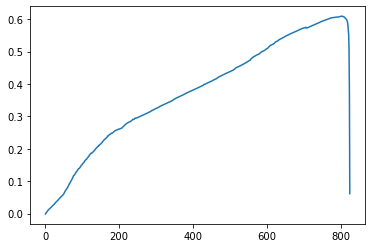

In [23]:
CDF['1'].plot()

In [24]:
CDF['1'].max()

0.6092536147020656